## Weather Forecast Dataset


The data contains  2,500 weather observations, it’s a simple yet practical dataset for learning how to predict rainfall based on various weather conditions.


https://www.kaggle.com/datasets/zeeshier/weather-forecast-dataset?resource=download

## Session 1 - Introduction and Initial Setup

The **Aim** of the notebook is to demonstrate how machine learning works with open source, from training to deployment of model The machine learning system we'll build during this program consists of  pipelines: A training pipeline, an inference pipeline, a deployment pipeline.

In [1]:
import os
import json
import logging
import sys
import boto3
from io import StringIO 
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}"])


DATA_FILEPATH = "kaggle_data/weather_forecast_data.csv"

## Session 2 - Exploratory Data Analysis

The goal of this session is to understand the data and the problem we are trying to solve.

In [3]:
weather = pd.read_csv(DATA_FILEPATH)
weather.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


We can see the dataset contains the following columns:


1. **temperature**: Recorded temperature in degrees Celsius (°C).

2. **humidity**: Humidity level as a percentage (%).

3. **wind_speed**: Wind speed measured in meters per second (m/s).

4. **cloud_cover**: Cloud cover percentage (%), indicating the extent of cloud coverage in the sky.

5. **pressure**: Atmospheric pressure in hectopascals (hPa).

6. **rain**: Binary label indicating whether it rained on that day (`rain` for rainy days, `no rain` for non-rainy days).


In [4]:
weather.describe(include="all")

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,no rain
freq,NaN,NaN,NaN,NaN,NaN,2186
mean,22.581725,64.347094,9.906255,49.658104,1014.312336,NaN
std,7.326996,19.954739,5.780316,29.123104,20.196433,NaN
min,10.001842,30.005071,0.009819,0.015038,980.014486,NaN
25%,16.359398,47.339815,4.761909,23.900016,996.938630,NaN
50%,22.536448,63.920797,9.908572,49.488284,1013.433035,NaN
75%,28.976476,81.561021,14.948408,75.324140,1031.735067,NaN


In [5]:
# list the column types
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Wind_Speed   2500 non-null   float64
 3   Cloud_Cover  2500 non-null   float64
 4   Pressure     2500 non-null   float64
 5   Rain         2500 non-null   object 
dtypes: float64(5), object(1)
memory usage: 117.3+ KB


In [6]:
# distribution of values for categorical data

rain_distribution= weather["Rain"].value_counts()

print(rain_distribution)

Rain
no rain    2186
rain        314
Name: count, dtype: int64


In [7]:
## Let's display again the number of missing values:

weather.isna().sum()

Temperature    0
Humidity       0
Wind_Speed     0
Cloud_Cover    0
Pressure       0
Rain           0
dtype: int64

Text(0, 0.5, 'Count')

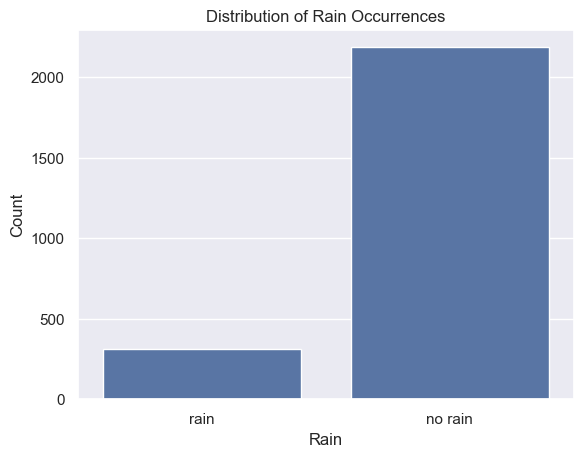

In [8]:
# Set the style of the plots
sns.set(style="darkgrid")

# Count plot for 'Rain'
sns.countplot(data=weather, x='Rain')
plt.title("Distribution of Rain Occurrences")
plt.xlabel("Rain")
plt.ylabel("Count")


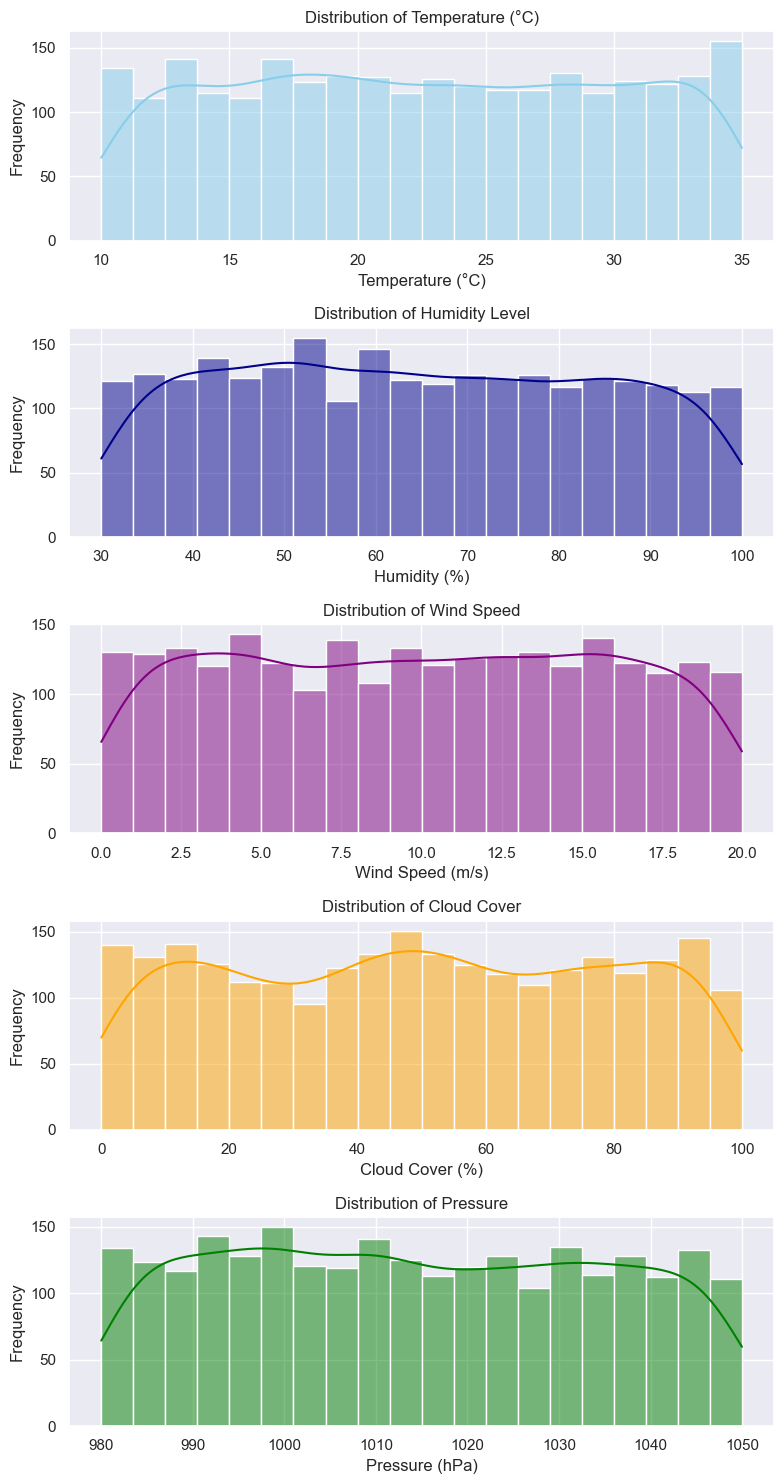

In [9]:
# Create a figure and an array of subplots 
fig, axs = plt.subplots(5, 1, figsize=(8, 15))  

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.4)

# Plot 1: Distribution of 'Temperature'
sns.histplot(data=weather, x='Temperature', bins=20, kde=True, color='skyblue', ax=axs[0])
axs[0].set_title("Distribution of Temperature (°C)")
axs[0].set_xlabel("Temperature (°C)")
axs[0].set_ylabel("Frequency")

# Plot 2: Distribution of 'Humidity'
sns.histplot(data=weather, x='Humidity', bins=20, kde=True, color='darkblue', ax=axs[1])
axs[1].set_title("Distribution of Humidity Level")
axs[1].set_xlabel("Humidity (%)")
axs[1].set_ylabel("Frequency")

# Plot 3: Distribution of 'Wind_Speed'
sns.histplot(data=weather, x='Wind_Speed', bins=20, kde=True, color='purple', ax=axs[2])
axs[2].set_title("Distribution of Wind Speed")
axs[2].set_xlabel("Wind Speed (m/s)")
axs[2].set_ylabel("Frequency")

# Plot 4: Distribution of 'Cloud_Cover'
sns.histplot(data=weather, x='Cloud_Cover', bins=20, kde=True, color='orange', ax=axs[3])
axs[3].set_title("Distribution of Cloud Cover")
axs[3].set_xlabel("Cloud Cover (%)")
axs[3].set_ylabel("Frequency")

# Plot 5: Distribution of 'Pressure'
sns.histplot(data=weather, x='Pressure', bins=20, kde=True, color='green', ax=axs[4])
axs[4].set_title("Distribution of Pressure")
axs[4].set_xlabel("Pressure (hPa)")
axs[4].set_ylabel("Frequency")

# Display the final plot with all subplots
plt.tight_layout()
plt.show()


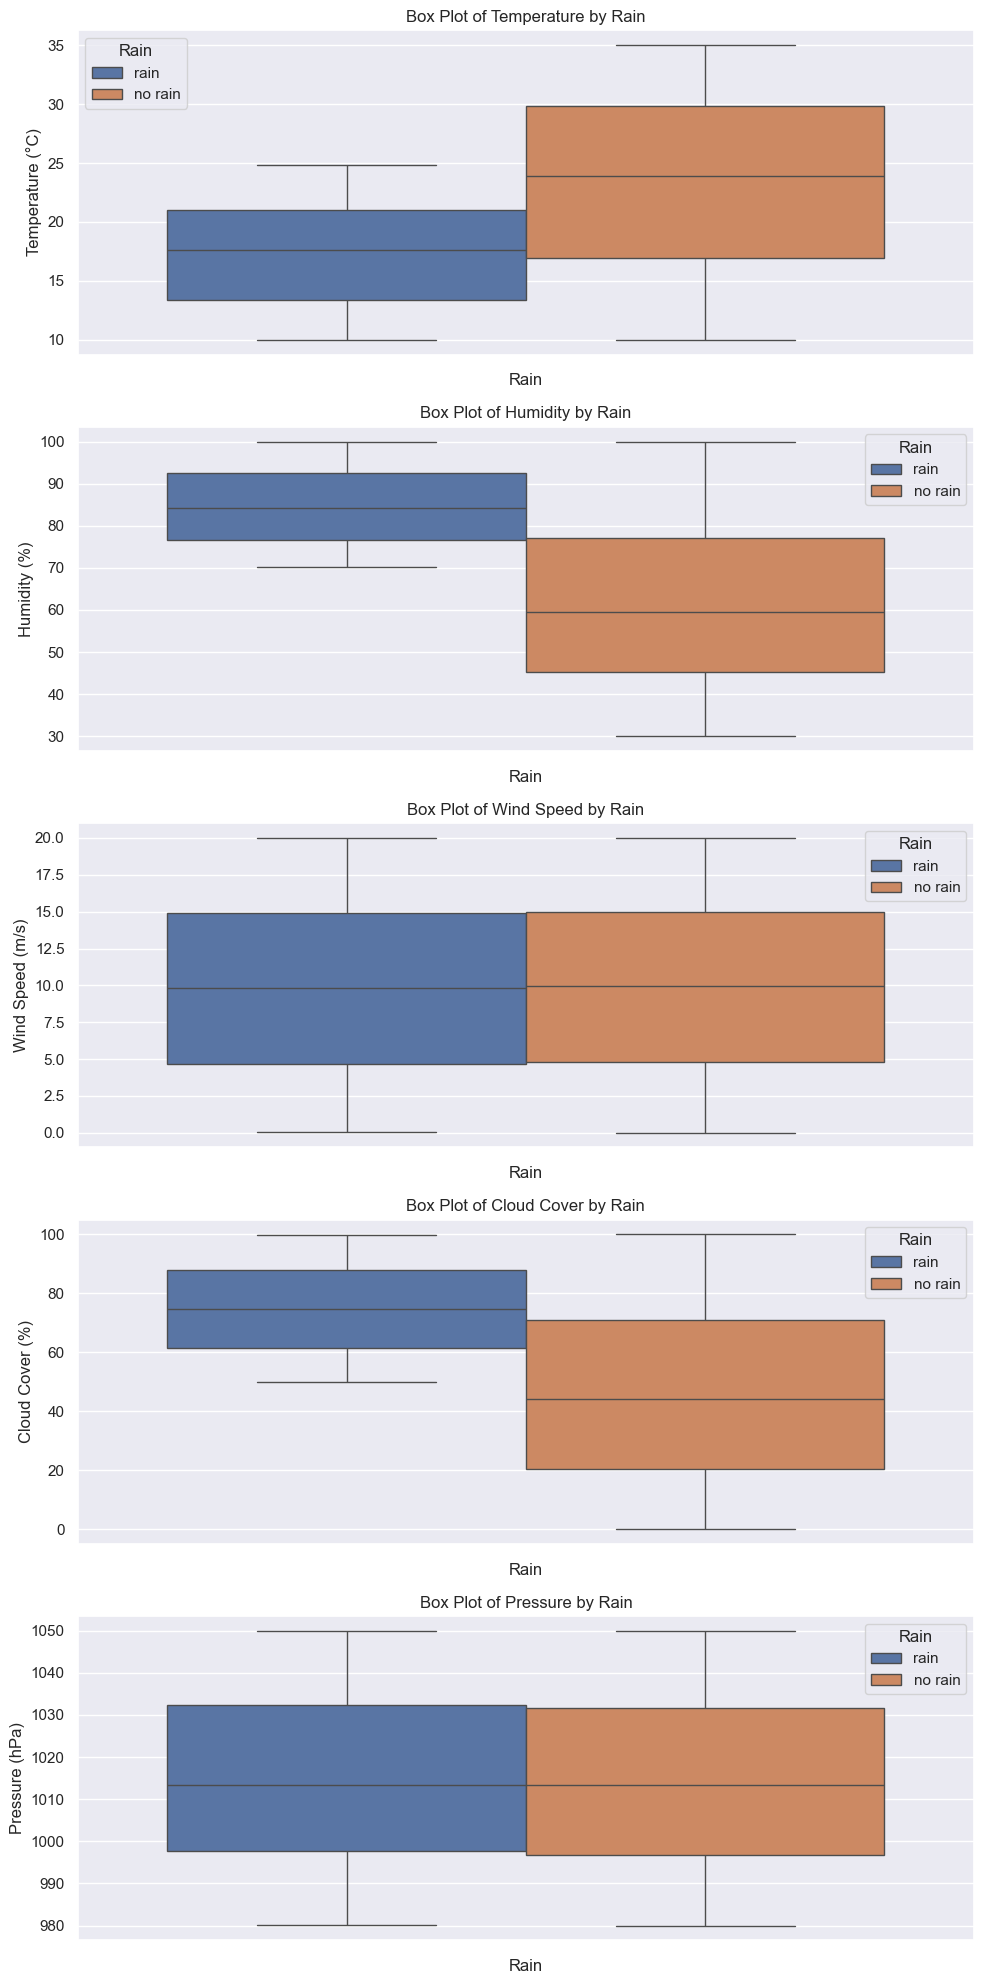

In [10]:
# Create a figure and an array of subplots for each box plot
fig, axs = plt.subplots(5, 1, figsize=(10, 20))  # 5 rows for each variable

# Plot 1: Box plot for 'Temperature'
sns.boxplot(data=weather, hue ='Rain', y='Temperature', ax=axs[0], legend = True)
axs[0].set_title("Box Plot of Temperature by Rain")
axs[0].set_xlabel("Rain")
axs[0].set_ylabel("Temperature (°C)")

# Plot 2: Box plot for 'Humidity'
sns.boxplot(data=weather, hue='Rain', y='Humidity', ax=axs[1], legend = True)
axs[1].set_title("Box Plot of Humidity by Rain")
axs[1].set_xlabel("Rain")
axs[1].set_ylabel("Humidity (%)")

# Plot 3: Box plot for 'Wind_Speed'
sns.boxplot(data=weather, hue='Rain', y='Wind_Speed', ax=axs[2], legend = True)
axs[2].set_title("Box Plot of Wind Speed by Rain")
axs[2].set_xlabel("Rain")
axs[2].set_ylabel("Wind Speed (m/s)")

# Plot 4: Box plot for 'Cloud_Cover'
sns.boxplot(data=weather, hue='Rain', y='Cloud_Cover', ax=axs[3], legend = True)
axs[3].set_title("Box Plot of Cloud Cover by Rain")
axs[3].set_xlabel("Rain")
axs[3].set_ylabel("Cloud Cover (%)")

# Plot 5: Box plot for 'Pressure'
sns.boxplot(data=weather, hue='Rain', y='Pressure', ax=axs[4], legend = True)
axs[4].set_title("Box Plot of Pressure by Rain")
axs[4].set_xlabel("Rain")
axs[4].set_ylabel("Pressure (hPa)")

# Adjust layout for readability
plt.tight_layout()
plt.show()


#### The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

In [11]:

weather.cov(numeric_only=True)

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
Temperature,53.684875,-2.064280,-0.209927,1.415202,-1.108155
Humidity,-2.064280,398.191615,0.440186,4.209518,-12.932167
Wind_Speed,-0.209927,0.440186,33.412053,-0.068111,2.191420
Cloud_Cover,1.415202,4.209518,-0.068111,848.155167,13.587282
Pressure,-1.108155,-12.932167,2.191420,13.587282,407.895898


### Interpretation of the Covariance Matrix

The matrix provides  a **covariance matrix** for the variables in the dataset: `Temperature`, `Humidity`, `Wind_Speed`, `Cloud_Cover`, and `Pressure`. Each cell represents the covariance between pairs of variables.

#### Diagonal Values
- The diagonal values represent the **variance** of each variable (since each variable is compared to itself). For example:
  - **Temperature** has a variance of `53.684875`.
  - **Humidity** has a variance of `398.191615`.
  - Higher variance indicates that values for the variable are more spread out from the mean.

#### Off-Diagonal Values (Covariances)
- Off-diagonal values represent the **covariance** between different pairs of variables. 
- Positive covariance values indicate that the two variables increase together, while negative values indicate that as one variable increases, the other tends to decrease.
- Covariances close to zero suggest little to no linear relationship between variables.

#### Pairwise Interpretations
- **Temperature and Humidity** (`-2.064280`): A near-zero, slightly negative covariance, indicating that `Temperature` and `Humidity` have a minimal inverse relationship.
- **Temperature and Wind_Speed** (`-0.209927`): Another near-zero covariance, suggesting a very weak negative association.
- **Humidity and Pressure** (`-12.932167`): A small negative covariance, suggesting a slight inverse relationship.
- **Cloud_Cover and Pressure** (`13.587282`): A positive covariance, implying that as `Cloud_Cover` increases, `Pressure` also tends to increase, albeit weakly.

#### High Variances
- **Cloud_Cover** has the highest variance (`848.155167`), suggesting the values for cloud cover are highly spread out.
- **Humidity** and **Pressure** also show high variances, indicating greater variability in these values.

### Summary
This matrix provides insight into the relationships between these variables:
- Most of the covariances are near zero, indicating weak or negligible linear relationships.
- **Cloud_Cover** and **Pressure** have the most noticeable positive covariance.
- Variance values (on the diagonal) highlight which variables are more variable (e.g., **Cloud_Cover**, **Humidity**) and which are less so (e.g., **Wind_Speed**).


##### Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:

In [12]:
weather.corr(numeric_only=True)

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
Temperature,1.000000,-0.014119,-0.004957,0.006632,-0.007489
Humidity,-0.014119,1.000000,0.003816,0.007244,-0.032089
Wind_Speed,-0.004957,0.003816,1.000000,-0.000405,0.018772
Cloud_Cover,0.006632,0.007244,-0.000405,1.000000,0.023100
Pressure,-0.007489,-0.032089,0.018772,0.023100,1.000000


### Interpretation of the Correlation Matrix

The matrix provided is a **correlation matrix** for the variables in the dataset: `Temperature`, `Humidity`, `Wind_Speed`, `Cloud_Cover`, and `Pressure`. Each cell shows the correlation coefficient between pairs of variables, with values ranging from -1 to 1.

- **1** indicates a perfect positive correlation.
- **-1** indicates a perfect negative correlation.
- **0** indicates no linear relationship.

#### Key Observations

1. **Diagonal Values**:
   - Each diagonal value is **1** because each variable is perfectly correlated with itself.

2. **Off-Diagonal Values (Correlations)**:
   - Off-diagonal values represent the correlation between different pairs of variables.
   - **Positive values** indicate that as one variable increases, the other tends to increase.
   - **Negative values** indicate that as one variable increases, the other tends to decrease.
   - **Values close to 0** suggest a weak or negligible linear relationship between variables.

#### Pairwise Interpretations

- **Temperature and Humidity** (`-0.014119`): Very weak negative correlation, indicating virtually no linear relationship between temperature and humidity.
- **Temperature and Wind_Speed** (`-0.004957`): Near-zero correlation, indicating no linear relationship.
- **Humidity and Pressure** (`-0.032089`): Slight negative correlation, but very close to zero, suggesting minimal interaction.
- **Cloud_Cover and Pressure** (`0.023100`): Very weak positive correlation, indicating a negligible relationship between these two variables.
- **Wind_Speed and Pressure** (`0.018772`): Slightly positive, but effectively no linear association.

### Summary

This matrix reveals that:
- **Most correlations are very close to zero**, indicating weak or negligible linear relationships between the variables.
- The **highest correlation** observed is between **Cloud_Cover** and **Pressure** (`0.023100`), but even this is too low to imply a strong linear relationship.
- **Temperature, Humidity, Wind_Speed, Cloud_Cover, and Pressure** appear to be largely independent of one another in terms of linear association.


In [13]:
# Select only float or int columns
numeric_columns = weather.select_dtypes(include=['float', 'int']).columns



In [14]:
Q3 = weather.Temperature.quantile(0.75)

In [15]:
Q1 = weather.Temperature.quantile(0.25)

In [16]:
IQR = Q3 - Q1
IQR,  Q3, Q1

(12.617077692815172, 28.976475724835588, 16.359398032020415)

In [17]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-2.5662185072023433, 47.902092264058346)

In [18]:
#look out for outliers
# Select only float or int columns
numeric_columns = weather.select_dtypes(include=['float', 'int']).columns

# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #values below lowerbound and above the upper bound are tagged outliers
    values = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return values




# Detect outliers for each numerical column
for column in numeric_columns:
    answers = detect_outliers_iqr(weather, column)
    print(f"Outliers in {column}:")
    print(answers)
    print("\n")

Outliers in Temperature:
Empty DataFrame
Columns: [Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, Rain]
Index: []


Outliers in Humidity:
Empty DataFrame
Columns: [Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, Rain]
Index: []


Outliers in Wind_Speed:
Empty DataFrame
Columns: [Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, Rain]
Index: []


Outliers in Cloud_Cover:
Empty DataFrame
Columns: [Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, Rain]
Index: []


Outliers in Pressure:
Empty DataFrame
Columns: [Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, Rain]
Index: []




### Using ANOVA and T-Tests for Predictive Insights

While ANOVA and t-tests do not directly determine predictive power (which is better assessed using classification models), they help identify if there are **statistically significant differences** in the numerical variable based on the categories. This can be an indicator that the numerical variable might help **differentiate or classify** the categories of the categorical target.

In [19]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Performing ANOVA to analyze if 'Temperature' differs significantly across 'admission' categories
anova_model = ols('Temperature ~ C(Rain)', data=weather).fit()  # Fit the ANOVA model using Temperature as the dependent variable
anova_results = sm.stats.anova_lm(anova_model, typ=2)  # Calculate ANOVA table

# Display the ANOVA table with a descriptive message
print("\n=== ANOVA Table: Analysis of Temperature across Admission Categories ===")
print(anova_results)



=== ANOVA Table: Analysis of Temperature across Admission Categories ===
                 sum_sq      df           F        PR(>F)
C(Rain)     9484.070011     1.0  190.024581  1.016240e-41
Residual  124674.432672  2498.0         NaN           NaN


### ANOVA Table: Analysis of Temperature across Rain Categories

- **PR(>F) (P-Value):**
  - The p-value is `1.016240e-41`, which is extremely small.
  - This translates to `0.000...101624`, with 40 zeros before the 1, far below typical significance levels (e.g., 0.05 or 0.01).
  - This tiny p-value suggests that we can reject the null hypothesis, indicating a significant difference in the mean `Temperature` across the `Rain` categories.

- **Residual:**
  - The residual row represents the unexplained variability in `Temperature` that is not accounted for by the `Rain` categories.

- **Interpretation:**
  - The ANOVA test results indicate that the mean `Temperature` differs significantly between the `Rain` categories.
  - Given the very small p-value (`1.016240e-41`), it’s extremely unlikely that the observed differences in `Temperature` are due to random chance.
  - Therefore, we conclude that the `Rain` status has a significant effect on the average `Temperature`.


In [20]:
#Calculate the mean GMAT score for each admission category
rain_mean = weather[weather['Rain'] == 'rain']['Temperature'].mean()
no_rain_mean = weather[weather['Rain'] == 'no rain']['Temperature'].mean()


# Print the mean temperature scores for each admission category
print(f"Mean temperature for when it rains  is : {rain_mean:.2f}")
print(f"Mean temperature for when it  does not rains  is : {no_rain_mean:.2f}")


Mean temperature for when it rains  is : 17.44
Mean temperature for when it  does not rains  is : 23.32


In [21]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Performing ANOVA to analyze if 'Temperature' differs significantly across 'admission' categories
anova_model = ols('Wind_Speed ~ C(Rain)', data=weather).fit()  # Fit the ANOVA model using Temperature as the dependent variable
anova_results = sm.stats.anova_lm(anova_model, typ=2)  # Calculate ANOVA table

# Display the ANOVA table with a descriptive message
print("\n=== ANOVA Table: Analysis of Temperature across Admission Categories ===")
print(anova_results)


=== ANOVA Table: Analysis of Temperature across Admission Categories ===
                sum_sq      df        F    PR(>F)
C(Rain)       0.161116     1.0  0.00482  0.944655
Residual  83496.560527  2498.0      NaN       NaN


### ANOVA Table: Analysis of Wind speed across Rain Categories

- **PR(>F) (P-Value):**
  - The p-value is `0.944655`, which is very large and far above typical significance levels (e.g., 0.05 or 0.01).
  - This high p-value suggests that we **fail to reject the null hypothesis**, indicating that there is **no significant difference** in the mean `Temperature` across the `Rain` categories.

- **Residual:**
  - The residual row represents the unexplained variability in `Temperature` that is not accounted for by the `Rain` categories.
  - Here, the residual sum of squares is `83496.560527`, showing the total variation in `Temperature` not explained by whether it rained or not.

- **Interpretation:**
  - The ANOVA test results indicate that the mean `Temperature` does **not differ significantly** between the `Rain` categories.
  - Given the high p-value (`0.944655`), it’s likely that any observed differences in `Temperature` across `Rain` categories are due to random chance.
  - Therefore, we conclude that `Rain` status **does not have a significant effect** on the average `Temperature`.


In [22]:
#Calculate the mean GMAT score for each admission category
rain_mean = weather[weather['Rain'] == 'rain']['Wind_Speed'].mean()
no_rain_mean = weather[weather['Rain'] == 'no rain']['Wind_Speed'].mean()


# Print the mean temperature scores for each admission category
print(f"Mean wind speed for when it rains  is : {rain_mean:.2f}")
print(f"Mean wind speed for when it  does not rains  is : {no_rain_mean:.2f}")

Mean wind speed for when it rains  is : 9.89
Mean wind speed for when it  does not rains  is : 9.91


## Session 3 - Splitting and Transforming the Data

in this session, going to write python files thats help install all packages split data,transform data and  train a model


In [23]:
weather.head(5)

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [12]:
#run the command in terminal
import mlflow
#!mlflow server --host 127.0.0.1 --port 5000
!export MLFLOW_TRACKING_URI="http://127.0.0.1:5000"
mlflow.set_tracking_uri("http://127.0.0.1:5000")


In [13]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)

In [13]:
%%writefile {CODE_FOLDER}/common.py
# | filename: script.py
# | code-line-numbers: true

import logging
import logging.config
import os
import sys
import time
from io import StringIO
from pathlib import Path
import numpy as np
from metaflow import current

import pandas as pd
from metaflow import S3, IncludeFile, current


PYTHON = "3.12"
PACKAGES = {
    "scikit-learn": "1.5.2",
    "pandas": "2.2.3",
    "numpy": "2.1.1",
    "keras": "3.6.0",
    "jax[cpu]": "0.4.35",
    "boto3": "1.35.32",
    "packaging": "24.1",
    "mlflow": "2.17.2",
    "setuptools": "75.1.0",
    "requests": "2.32.3",
    "evidently": "0.4.33",
    "azure-ai-ml": "1.19.0",
    "azureml-mlflow": "1.57.0.post1",
    "python-dotenv": "1.0.1",
    "xgboost": "2.1.1",
    "psutil": "5.9.5"
}


scale_pos_weight = 6.95
#early_stopping_rounds = 10




class FlowMixin:

    
    """Base class used to share code across multiple pipelines."""
   


    # IncludeFile from Metaflow to include local or S3-based files
    dataset = IncludeFile(
        "weather_report",
        is_text=True,
        help=(
            "The local copy of the weather dataset. This file will be included in the "
            "flow and used whenever the flow is executed in development mode."
        ),
        default="kaggle_data/weather_forecast_data.csv",
    )

    def load_dataset(self):
        """Load and prepare the dataset.
        
        Loads data from S3 in production mode or locally in development.
        """

        import numpy as np

        if current.is_production:
            dataset = os.environ.get("DATASET", self.dataset)

            with S3(s3root=dataset) as s3:
                files = s3.get_all()

                logging.info("Found %d file(s) in remote location", len(files))

                raw_data = [pd.read_csv(StringIO(file.text)) for file in files]
                data = pd.concat(raw_data)
        else:
            # In development, load from the local dataset string.
            
            dataset_folder = os.environ.get("DATA_FILEPATH", "kaggle_data/")

            # Find all CSV files in the directory
            # then create a python list of their data path
            csv_files = list(Path(dataset_folder).glob("*.csv"))
        
            if not csv_files:
                
                raise FileNotFoundError(f"No CSV files found in directory: {dataset_folder}")
        
            logging.info("Found %d CSV file(s) in the directory: %s", len(csv_files), dataset_folder)
        
            # Combine all CSV files into a single DataFrame
            raw_data = []
            for file in csv_files:
                try:
                    data_chunk = pd.read_csv(file)
                    raw_data.append(data_chunk)
                    logging.info("Loaded %d records from file: %s", len(data_chunk), file)
                except Exception as e:
                    logging.warning("Failed to load file %s: %s", file, str(e))
        
            if not raw_data:
                raise ValueError("No valid data could be loaded from the CSV files.")
        
            data = pd.concat(raw_data, ignore_index=True)
        

        # Shuffle the dataset for reproducibility
        seed = int(time.time() * 1000) if current.is_production else  42
        generator = np.random.default_rng(seed=seed)
        data = data.sample(frac=1, random_state=generator)

        logging.info("Loaded dataset with %d samples", len(data))

        return data

def packages(*names: str):
    """Return a dictionary of the specified packages and their version."""

    return {name: PACKAGES[name] for name in names if name in PACKAGES}

def configure_logging():
    """Configure logging handlers and return a logger instance."""
    
    if Path("logging.conf").exists():
        logging.config.fileConfig("logging.conf")
    else:
        logging.basicConfig(
            format="%(asctime)s [%(levelname)s] %(message)s",
            handlers=[logging.StreamHandler(sys.stdout)],
            level=logging.INFO,
        )


def build_target_transformer():
    """Build a Scikit-Learn transformer to preprocess the target column."""
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OrdinalEncoder

    return ColumnTransformer(
        transformers=[('rain_status', OrdinalEncoder(), [0])],
    )


def build_features_transformer():
    """Build a Scikit-Learn transformer to preprocess the feature columns."""
    from sklearn.compose import ColumnTransformer, make_column_selector
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    # Pipeline for numeric data only
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    # Apply the numeric transformer to all columns, assuming they are all numeric
    return ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_include="number"),  # Selects only numeric columns
            ),
        ],
    )


def build_model(scale_pos_weight):
    """Build and compile an XGBoost classifier to predict the weather."""
    from xgboost import XGBClassifier

    # Set scale_pos_weight for imbalanced classes (example value, adjust as needed)
    

    model = XGBClassifier(
        #early_stopping_rounds=10,
        eval_metric=['logloss', 'aucpr', 'error'],
        scale_pos_weight= 6.95,
        random_state=42
    )

    return model


Overwriting code/common.py


In [15]:
%%writefile {CODE_FOLDER}/training.py

# | filename: script.py
# | code-line-numbers: true

# | filename: script.py
# | code-line-numbers: true
import logging
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import joblib
import matplotlib

os.environ['MPLBACKEND'] = 'Agg'  # Set backend through environment variable
import matplotlib
matplotlib.use('Agg')  # Set backend explicitly
import matplotlib.pyplot as plt

from common import (
    PYTHON,
    #early_stopping_rounds,
    scale_pos_weight,
    FlowMixin,
    build_features_transformer,
    build_model,
    build_target_transformer,
    configure_logging,
    packages,
)

from inference import Model

from metaflow import (
    FlowSpec,
    Parameter,
    card,
    current,
    environment,
    project,
    pypi_base,
    resources,
    step,
)

configure_logging()

@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages(
        "scikit-learn",
        "pandas",
        "numpy",
        "keras",
        "jax[cpu]",
        "boto3",
        "packaging",
        "mlflow",
        "setuptools",
        "python-dotenv",
        "xgboost"
    ),
)

class Training(FlowSpec, FlowMixin):
    """Training pipeline for predicting rainfall conditions."""

    accuracy_threshold = Parameter(
        "accuracy_threshold",
        help="Minimum accuracy threshold required to register the model.",
        default=0.7
    )
    recall_threshold = Parameter(
        "recall_threshold",
        help="Minimum recall threshold required to register the model.",
        default=0.7
    )

    @card
    @environment(
        vars={"MLFLOW_TRACKING_URI": os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")},
    )
    @step
    def start(self):
        """Start and prepare the Training pipeline."""
        import mlflow

        self.mlflow_tracking_url = os.getenv("MLFLOW_TRACKING_URI")
        logging.info("MLFLOW_TRACKING_URI %s", self.mlflow_tracking_url)

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        self.mode = "production" if current.is_production else "development"
        logging.info("Running flow in %s mode.", self.mode)

        self.data = self.load_dataset()
        
        X = self.data.drop(columns=['Rain'])
        y = self.data['Rain']
        
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)
        val_data = pd.concat([X_val, y_val], axis=1)

        data_dir = Path('data')
        untransformed_dir = data_dir / 'untransformed_dataset'
        untransformed_dir.mkdir(parents=True, exist_ok=True)

        train_data.to_csv(untransformed_dir / 'train.csv', index=False)
        test_data.to_csv(untransformed_dir / 'test.csv', index=False)
        val_data.to_csv(untransformed_dir / 'validation.csv', index=False)

        print(f"Training set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")
        
        self.columns=X_test.columns


        self.X_untransformed_train = X_train
        self.X_untransformed_val = X_val
        self.X_untransformed_test = X_test
        self.y_untransformed_train = y_train
        self.y_untransformed_val = y_val
        self.y_untransformed_test = y_test

        try:
            run = mlflow.start_run(run_name=current.run_id)
            self.mlflow_run_id = run.info.run_id
        except Exception as e:
            message = f"Failed to connect to MLflow server {self.mlflow_tracking_url}."
            raise RuntimeError(message) from e

        self.training_parameters = {
            "scale_pos_weight": scale_pos_weight,
           # "early_stopping_rounds": early_stopping_rounds,
        }

        self.next(self.transform)

    @card
    @step
    def transform(self):
        """Apply transformation to the entire dataset before model training."""
        self.target_transformer = build_target_transformer()
        self.features_transformer = build_features_transformer()

        logging.info("Transforming data...")

        
        self.y_train = self.y_untransformed_train.to_frame()
        self.y_test = self.y_untransformed_test.to_frame()
        self.y_val = self.y_untransformed_val.to_frame()

        self.y_train = pd.DataFrame(self.target_transformer.fit_transform(self.y_train),columns=["rain"])
        self.y_test = pd.DataFrame(self.target_transformer.transform(self.y_test),columns=["rain"])
        self.y_val = pd.DataFrame(self.target_transformer.transform(self.y_val),columns=["rain"])

        self.X_train = pd.DataFrame(self.features_transformer.fit_transform(self.X_untransformed_train), columns=self.columns)
        self.X_test = pd.DataFrame(self.features_transformer.transform(self.X_untransformed_test), columns=self.columns)
        self.X_val = pd.DataFrame(self.features_transformer.transform(self.X_untransformed_val),columns=self.columns)

        transformed_dir = Path('data') / 'transformed_dataset'
        transformed_dir.mkdir(parents=True, exist_ok=True)

        pd.concat([self.X_train, self.y_train], axis=1).to_csv(transformed_dir / 'train.csv', index=False)
        pd.concat([self.X_test, self.y_test], axis=1).to_csv(transformed_dir / 'test.csv', index=False)
        pd.concat([self.X_val, self.y_val], axis=1).to_csv(transformed_dir / 'validation.csv', index=False)

        self.X = pd.concat([self.X_train, self.X_val], axis=0, ignore_index=True)
        self.y = pd.concat([self.y_train, self.y_val], axis=0, ignore_index=True)

        

        print(f"X_data shape: {self.X.shape}")
        print(f"y_data shape: {self.y.shape}")

        self.next(self.cross_validation, self.train_model)

    @card
    @step
    def cross_validation(self):
        """Generate the indices to split the data for the cross-validation process."""
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        self.folds = list(enumerate(skf.split(self.X, self.y)))
        self.next(self.unpack_fold, foreach="folds")

    @card
    @step
    def unpack_fold(self):
        """Transform the data to build a model during the cross-validation process."""
        self.fold, (self.train_indices, self.test_indices) = self.input
        self.y_train_fold = self.y.iloc[self.train_indices]
        self.y_test_fold = self.y.iloc[self.test_indices]
        self.X_train_fold = self.X.iloc[self.train_indices]
        self.X_test_fold = self.X.iloc[self.test_indices]
        self.next(self.train_fold)

    @card
    @resources(memory=4096)
    @step
    def train_fold(self):
        """Train a model as part of the cross-validation process."""
        import mlflow

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        with (
            mlflow.start_run(run_id=self.mlflow_run_id),
            mlflow.start_run(run_name=f"cross-validation-fold-{self.fold}", nested=True) as run,
        ):
            self.mlflow_fold_run_id = run.info.run_id
            mlflow.autolog(log_models=False)

            self.model = build_model(scale_pos_weight=6.95)
            self.model.fit(self.X_train_fold, self.y_train_fold, verbose=0, eval_set=[(self.X_test_fold, self.y_test_fold)])
            self.eval_result = self.model.evals_result_

        self.next(self.evaluate_fold)

    @card
    @step
    def evaluate_fold(self):
        """Evaluate the model we created as part of the cross-validation process."""
        import mlflow
        self.mlflow_tracking_uri = self.mlflow_tracking_url

        self.loss = self.eval_result['validation_0']['logloss'][10]
        self.aucpr = self.eval_result['validation_0']['aucpr'][10]
        self.error = self.eval_result['validation_0']['error'][10]
        self.accuracy = 1 - self.error

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        with mlflow.start_run(run_id=self.mlflow_fold_run_id):
            mlflow.log_metrics({"test_loss": self.loss, "test_accuracy": self.accuracy, "precision_recall": self.aucpr})

        self.next(self.evaluate_model)
        

    @card
    @environment(
        vars={"MLFLOW_TRACKING_URI": os.getenv("MLFLOW_TRACKING_URI", "http://127.0.0.1:5000")},
    )
    @step
    def evaluate_model(self, inputs):
        """Evaluate the overall cross-validation process."""
       
        import mlflow
        import numpy as np

        # We need access to the `mlflow_run_id` and `mlflow_tracking_uri` artifacts
        # that we set at the start of the flow, but since we are in a join step, we
        # need to merge the artifacts from the incoming branches to make them
        # available.
        self.merge_artifacts(inputs, include=["mlflow_run_id", "mlflow_tracking_uri"])
        
        # Gather accuracies and losses from each fold
        accuracies = [input.accuracy for input in inputs]
        losses = [input.loss for input in inputs]
        
        # Calculate mean and standard deviation for accuracy and loss
        self.accuracy = np.mean(accuracies)
        self.accuracy_std = np.std(accuracies)
        self.loss = np.mean(losses)
        self.loss_std = np.std(losses)
        
        # Log metrics to MLflow
        with mlflow.start_run(run_id=self.mlflow_run_id):
            mlflow.log_metrics(
                {
                    "cross_validation_accuracy": self.accuracy,
                    "cross_validation_accuracy_std": self.accuracy_std,
                    "cross_validation_loss": self.loss,
                    "cross_validation_loss_std": self.loss_std,
                },
            )
            
        self.next(self.register_model)

    @card
    @resources(memory=4096)
    @step
    def train_model(self):
        """Train the model that will be deployed to production."""
        import mlflow
        import numpy as np
        from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        with mlflow.start_run(run_id=self.mlflow_run_id):
            mlflow.autolog(log_models=False)

            self.model = build_model(scale_pos_weight=6.95)
            self.model.fit(self.X, self.y, verbose=0)
            mlflow.log_params(self.training_parameters)

            self.y_pred = self.model.predict(self.X_test)
            self.final_accuracy = accuracy_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.precision = precision_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.recall = recall_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.f1 = f1_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.conf_matrix = confusion_matrix(np.array(self.y_test).reshape(-1, 1), self.y_pred)

            feature_importance = pd.DataFrame({'feature': self.X.columns, 'importance': self.model.feature_importances_})
            print("\nTop Most Important Features:")
            print(feature_importance.sort_values('importance', ascending=False).head(5))
               # Log the source file to MLflow
            mlflow.log_artifact(__file__, "source")

            mlflow.log_metrics(
                {
                    "final_accuracy": self.final_accuracy,
                    "precision": self.precision,
                    "recall": self.recall,
                },
            )

        self.next(self.register_model)

    @step
    def register_model(self, inputs):
        """Register the model in the Model Registry if it meets accuracy and recall thresholds."""
        import mlflow
        import tempfile

        self.merge_artifacts(inputs)

        if self.final_accuracy >= self.accuracy_threshold and self.recall >= self.recall_threshold:
            logging.info("Registering model...")
            mlflow.set_tracking_uri(self.mlflow_tracking_url)
            with mlflow.start_run(run_id=self.mlflow_run_id), tempfile.TemporaryDirectory() as directory:
                mlflow.pyfunc.log_model(
                    python_model=Model(data_capture=False),
                    registered_model_name="raining",
                    artifact_path="model",
                    code_paths=[(Path(__file__).parent / "inference.py").as_posix()],
                    artifacts=self._get_model_artifacts(directory),
                    pip_requirements=self._get_model_pip_requirements(),
                    signature=self._get_model_signature(),
                    example_no_conversion=True,
                )
        else:
            logging.info("Model did not meet accuracy or recall thresholds. Skipping registration.")

        self.next(self.end)

    @step
    def end(self):
        """End the Training pipeline."""
        logging.info("The pipeline finished successfully.")

    def _get_model_artifacts(self, directory: str):
        model_path = (Path(directory) / "raining.joblib").as_posix()
        joblib.dump(self.model, model_path)

        features_transformer_path = (Path(directory) / "features.joblib").as_posix()
        target_transformer_path = (Path(directory) / "target.joblib").as_posix()
        joblib.dump(self.features_transformer, features_transformer_path)
        joblib.dump(self.target_transformer, target_transformer_path)

        return {
            "model": model_path,
            "features_transformer": features_transformer_path,
            "target_transformer": target_transformer_path,
        }

    def _get_model_signature(self):
        from mlflow.models import infer_signature 

        return infer_signature(
            model_input={
                "Temperature": 19.738713,
                "Humidity": 75.263991,
                "Wind_Speed": 3.976084,
                "Cloud_Cover": 33.399872,
                "Pressure": 1042.225804,
            },
            model_output={"prediction": "Rain", "confidence": 0.90},
            params={"data_capture": False},
        )

    def _get_model_pip_requirements(self):
        """Return the list of required packages to run the model in production."""
        return [
            f"{package}=={version}"
            for package, version in packages(
                "scikit-learn",
                "pandas",
                "numpy",
                "xgboost",
                "keras",
                "jax[cpu]",
            ).items()
        ]


if __name__ == "__main__":
    Training()

Overwriting code/training.py


In [18]:
%%writefile {CODE_FOLDER}/inference.py

import logging
import logging.config
import os
import sqlite3
import uuid
from datetime import datetime, timezone
from typing import Any
import json

import joblib
import mlflow
import numpy as np
import pandas as pd
from mlflow.pyfunc import PythonModelContext

class Model(mlflow.pyfunc.PythonModel):
    """A custom model that can be used to make predictions.

    This model implements an inference pipeline with three phases: preprocessing,
    prediction, and postprocessing. The model will optionally store the input requests
    and predictions in a SQLite database.

    The [Custom MLflow Models with mlflow.pyfunc](https://mlflow.org/blog/custom-pyfunc)
    blog post is a great reference to understand how to use custom Python models in
    MLflow.
    """

    def __init__(
        self,
        data_collection_uri: str | None =  "rain.db",
        #creating a json file that can automatically have the data instead of the sql database, can deactivate by using  str | None
        json_lines_file: str = "rain_predictions.jsonl", 
        *,
        data_capture: bool = False,
    ) -> None:
        """Initialize the model.

        By default, the model will not collect the input requests and predictions. This
        behavior can be overwritten on individual requests.

        This constructor expects the connection URI to the storage medium where the data
        will be collected. By default, the data will be stored in a SQLite database
        named "penguins" and located in the root directory from where the model runs.
        You can override the location by using the 'DATA_COLLECTION_URI' environment
        variable.
        """
        self.data_capture = data_capture
        self.data_collection_uri = data_collection_uri
        self.json_lines_file = json_lines_file

    def load_context(self, context: PythonModelContext) -> None:
        """Load the transformers and the model specified as artifacts.

        This function is called only once as soon as the model is constructed.
        hence saving time in loading the transformers
        """
        import xgboost
        
        self._configure_logging()
        logging.info("Loading model context...")

        # If the DATA_COLLECTION_URI environment variable is set, we should use it
        # to specify the database filename. Otherwise, we'll use the default filename
        # specified when the model was instantiated.
        self.data_collection_uri = os.environ.get(
            "DATA_COLLECTION_URI",
            self.data_collection_uri,
        )
        #either as environment or we use the established file name "rain_predictions.jsonl"
        self.json_lines_file = os.environ.get("JSON_LINES_FILE", self.json_lines_file)
        
        logging.info("Data collection URI: %s", self.data_collection_uri)
        logging.info("JSON Lines file: %s", self.json_lines_file)

        # First, we need to load the transformation pipelines from the artifacts. These
        # will help us transform the input data and the output predictions. Notice that
        # these transformation pipelines are the ones we fitted during the training
        # phase.
        self.features_transformer = joblib.load(
            context.artifacts["features_transformer"],
        )
        self.target_transformer = joblib.load(context.artifacts["target_transformer"])

        # Then, we can load the Keras model we trained.
        self.model = joblib.load(context.artifacts["model"])

        logging.info("Model is ready to receive requests")

    def process_input(self, payload: pd.DataFrame) -> pd.DataFrame:
        """Process the input data received from the client.

        This method is responsible for transforming the input data received from the
        client into a format that can be used by the model.
        """
        logging.info("Transforming payload...")
        logging.debug(f"Input payload: {payload}")

        # We need to transform the payload using the transformer. This can raise an
        # exception if the payload is not valid, in which case we should return None
        # to indicate that the prediction should not be made.
        try:
            result = self.features_transformer.transform(payload)
            logging.debug(f"Transformed payload shape: {result.shape}")
            logging.debug(f"Transformed payload: {result}")
            return result
        except Exception:
            logging.exception("There was an error processing the payload.")
            return None

    def predict(
        self,
        context: PythonModelContext,  # noqa: ARG002
        model_input,
        params: dict[str, Any] | None = None,
    ) -> list:
        """Handle the request received from the client.

        This method is responsible for processing the input data received from the
        client, making a prediction using the model, and returning a readable response
        to the client.

        The caller can specify whether we should capture the input request and
        prediction by using the data_capture parameter when making a request.
        """
        if isinstance(model_input, (list, dict)):
            model_input = pd.DataFrame(model_input)
        
        logging.info(
            "Received prediction request with %d %s",
            len(model_input),
            "samples" if len(model_input) > 1 else "sample",
        )
        logging.debug(f"Model input: {model_input}")
        
        results = []
        errors = []
        model_successful_input = []

        for index, row in model_input.iterrows():
            try:
                transformed_payload = self.process_input(row.to_frame().T)
                
                if transformed_payload is not None:
                    logging.info("Making a prediction using the transformed payload...")
                    model_successful_input.append(row)
                    
                    # Get probability predictions
                    predictions = self.model.predict_proba(transformed_payload)
                    logging.debug(f"Raw probability predictions shape: {predictions.shape}")
                    logging.debug(f"Raw probability values: {predictions}")
                    
                    processed_output = self.process_output(predictions)
                    logging.debug(f"Processed output: {processed_output}")
                    
                    results.append(processed_output[0])

            except Exception as e:
                logging.exception("Error processing row at index %d: %s", index, e)
                errors.append({"index": index, "error": str(e)})
        
        # Capture data if conditions are met
        if (
            params
            and params.get("data_capture", False) is True
            or not params
            and self.data_capture
        ):
            self.capture(pd.DataFrame(model_successful_input), results)
            self.capture_to_jsonl(pd.DataFrame(model_successful_input), results)

        logging.info("Returning prediction to the client")
        logging.debug(f"Final results: {results}")

        return results

    def process_output(self, output: np.ndarray) -> list:
        """Process the prediction received from the model.

        This method is responsible for transforming the prediction received from the
        model into a readable format that will be returned to the client.
        """
        logging.info("Processing prediction received from the model...")
        logging.debug(f"Output shape: {output.shape}")
        logging.debug(f"Output values: {output}")

        result = []
        if output is not None:
            # Ensure the output is 2D
            if output.ndim == 1:
                output = output.reshape(1, -1)
                logging.debug(f"Reshaped output: {output}")
    
            prediction = np.argmax(output, axis=1)
            confidence = np.max(output, axis=1)
            
            logging.debug(f"Prediction indices: {prediction}")
            logging.debug(f"Confidence values: {confidence}")

            # Get classes from target transformer
            classes = self.target_transformer.named_transformers_[
                "rain_status"
            ].categories_[0]
            logging.debug(f"Available classes: {classes}")
            
            prediction = np.vectorize(lambda x: classes[x])(prediction)
            logging.debug(f"Mapped predictions: {prediction}")

            # Create final result
            result = [
                {"prediction": p.item(), "confidence": c.item()}
                for p, c in zip(prediction, confidence, strict=True)
            ]
            logging.debug(f"Final result: {result}")

        return result
            
    def capture(self, model_input: pd.DataFrame, model_output: list) -> None:
        """Save the input request and output prediction to the database.

        This method will save the input request and output prediction to a SQLite
        database. If the database doesn't exist, this function will create it.
        """
        logging.info("Storing input payload and predictions in the database...")

        connection = None
        try:
            connection = sqlite3.connect(self.data_collection_uri)

            # Let's create a copy from the model input so we can modify the DataFrame
            # before storing it in the database.
            data = model_input.copy()

            # We need to add the current time, the prediction and confidence columns
            # to the DataFrame to store everything together.
            data["date"] = datetime.now(timezone.utc)

            # Let's initialize the prediction and confidence columns with None. We'll
            # overwrite them later if the model output is not empty.
            data["prediction"] = None
            data["confidence"] = None

            # Let's also add a column to store the ground truth. This column can be
            # used by the labeling team to provide the actual rain status for the data for monitoring
            data["rain_status"] = None

            # If the model output is not empty, we should update the prediction and
            # confidence columns with the corresponding values.
            if model_output is not None and len(model_output) > 0:
                data["prediction"] = [item["prediction"] for item in model_output]
                data["confidence"] = [item["confidence"] for item in model_output]

            # Let's automatically generate a unique identified for each row in the
            # DataFrame. This will be helpful later when labeling the data.
            data["uuid"] = [str(uuid.uuid4()) for _ in range(len(data))]

            # Finally, we can save the data to the database.
            data.to_sql("data", connection, if_exists="append", index=False)

        except sqlite3.Error:
            logging.exception(
                "There was an error saving the input request and output prediction "
                "in the database.",
            )
        finally:
            if connection:
                connection.close()

    def capture_to_jsonl(self, model_input: pd.DataFrame, model_output: list) -> None:
        """Save the input request and output prediction to a JSON Lines file."""
        logging.info("Storing input payload and predictions in JSON Lines file...")
        
        try:
            data = model_input.copy()
            data["date"] = datetime.now(timezone.utc).isoformat()
            data["uuid"] = [str(uuid.uuid4()) for _ in range(len(data))]
            
            if model_output:
                data["prediction"] = [item["prediction"] for item in model_output]
                data["confidence"] = [item["confidence"] for item in model_output]
                # used by the labeling team to provide the actual rain status or ground truth for the data for monitoring
                data["rain_status"] = None
                
            # convert dataframe to json file
            records = data.to_dict(orient="records")
            
            # append each to the json
            with open(self.json_lines_file, "a") as f:
                for record in records:
                    json.dump(record, f)
                    f.write("\n")

        except Exception:
            logging.exception("Error saving input and output to JSON Lines file.")

    def _configure_logging(self):
        """Configure how the logging system will behave."""
        import sys
        from pathlib import Path

        if Path("logging.conf").exists():
            logging.config.fileConfig("logging.conf")
        else:
            logging.basicConfig(
                format="%(asctime)s [%(levelname)s] %(message)s",
                handlers=[logging.StreamHandler(sys.stdout)],
                level=logging.DEBUG,  # Changed to DEBUG for detailed logging
            )

Overwriting code/inference.py


In [19]:
!python code/training.py --environment=pypi run

Metaflow 2.12.28 executing Training for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-15 20:51:38.849 Bootstrapping virtual environment(s) ...
2024-12-15 20:51:39.102 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-15 20:51:39.277 Workflow starting (run-id 1734292299262030):
2024-12-15 20:51:39.341 [1734292299262030/start/1 (pid 3265)] Task is starting.
2024-12-15 20:51:41.508 [1734292299262030/start/1 (pid 3265)] 2024-12-15 20:51:41,508 [INFO] MLFLOW_TRACKING_URI http://127.0.0.1:5000
2024-12-15 20:51:41.509 [1734292299262030/start/1 (pid 3265)] 2024-12-15 20:51:41,508 [INFO] Running flow in development mode.
2024-12-15 20:51:41.509 [1734292299262030/start/1 (pid 3265)] 2024-12-15 20:51:41,508 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-15 20:51:41.514 [1734292299262030/start/1 (pid 3

In [ ]:
!python code/training.py --environment=pypi card server

### MODEL - DEPLOYMENT 

In [20]:
!curl -s -X GET "http://127.0.0.1:5000/api/2.0/mlflow/registered-models/get-latest-versions" \
-H "Content-Type: application/json" \
-d '{"name": "raining"}' | \
jq -r '.model_versions[0].version'

2


In [21]:
!curl -s -X GET "http://127.0.0.1:5000/api/2.0/mlflow/registered-models/get-latest-versions" \
-H "Content-Type: application/json" \
-d '{"name": "raining"}'

{
  "model_versions": [
    {
      "name": "raining",
      "version": "2",
      "creation_timestamp": 1734292364961,
      "last_updated_timestamp": 1734292364961,
      "current_stage": "None",
      "description": "",
      "source": "mlflow-artifacts:/0/36baca50b4414866af521e258f86a1f3/artifacts/model",
      "run_id": "36baca50b4414866af521e258f86a1f3",
      "status": "READY",
      "run_link": ""
    }
  ]
}

In [34]:
# Then proceed with serving
!mlflow models serve -m models:/raining/2 -h 0.0.0.0 -p 8080 --no-conda


2024/12/15 09:56:45 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/12/15 09:56:45 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 0.0.0.0:8080 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-12-15 09:56:45 +0100] [2369] [INFO] Starting gunicorn 23.0.0
[2024-12-15 09:56:45 +0100] [2369] [INFO] Listening at: http://0.0.0.0:8080 (2369)
[2024-12-15 09:56:45 +0100] [2369] [INFO] Using worker: sync
[2024-12-15 09:56:45 +0100] [2370] [INFO] Booting worker with pid: 2370
2024/12/15 09:56:47 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.17.2, required: mlflow==2.17.1)
 - numpy (current: 1.26.4, required: numpy==2.1.1)
 - xgboost (current: 2.1.2, required: xgboost==2.1.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environ

In [17]:
#this uses flask to serve and host the model
#run code in terminal
#!export MLFLOW_TRACKING_URI="http://127.0.0.1:5000"
#!mlflow models serve -m models:/raining/2 -h 0.0.0.0 -p 8080 --no-conda

In [22]:
!curl -X POST http://0.0.0.0:8080/invocations \
-H "Content-Type: application/json" \
-d '{"inputs": [{"Temperature": 25.069084, "Humidity": 83.072843, "Wind_Speed": 1.371992, "Cloud_Cover": 14.855784, "Pressure": 1007.231620}]}'


{"predictions": [{"prediction": "no rain", "confidence": 0.9996001124382019}]}

In [23]:
# Step 1: Create the JSON input as a Python dictionary
import json

input_data = {
    "inputs": [
        {"Temperature": 20.561237, "Humidity": 70.124678, "Wind_Speed": 3.485729, "Cloud_Cover": 25.372849, "Pressure": 1015.672348},
        {"Temperature": 15.762348, "Humidity": 90.472983, "Wind_Speed": 5.283467, "Cloud_Cover": 75.849376, "Pressure": 1002.347628},
        {"Temperature": 30.128437, "Humidity": 50.372948, "Wind_Speed": 2.472394, "Cloud_Cover": 10.238947, "Pressure": 1018.394827},
        {"Temperature": 10.237849, "Humidity": 95.283746, "Wind_Speed": 8.473920, "Cloud_Cover": 90.849372, "Pressure": 995.482937}
    ]
}

# Convert the dictionary to a JSON string
input_json = json.dumps(input_data)

# Step 2: Use the variable in the curl command
!curl -X POST http://0.0.0.0:8080/invocations \
-H "Content-Type: application/json" \
-d '{input_json}'



{"predictions": [{"prediction": "no rain", "confidence": 0.9994685649871826}, {"prediction": "rain", "confidence": 0.9997991919517517}, {"prediction": "no rain", "confidence": 0.9999126195907593}, {"prediction": "rain", "confidence": 0.9997991919517517}]}

In [24]:
# First, prepare the input data
#this example captures the data input
import json

# Create the complete request body including both inputs and params
request_data = {
    "inputs": [
        {"Temperature": 20.561237, "Humidity": 70.124678, "Wind_Speed": 3.485729, "Cloud_Cover": 25.372849, "Pressure": 1015.672348},
        {"Temperature": 15.762348, "Humidity": 90.472983, "Wind_Speed": 5.283467, "Cloud_Cover": 75.849376, "Pressure": 1002.347628},
        {"Temperature": 30.128437, "Humidity": 50.372948, "Wind_Speed": 2.472394, "Cloud_Cover": 10.238947, "Pressure": 1018.394827},
        {"Temperature": 10.237849, "Humidity": 95.283746, "Wind_Speed": 8.473920, "Cloud_Cover": 90.849372, "Pressure": 995.482937}
    ],
    "params": {
        "data_capture": True
    }
}

# Convert to JSON string
request_json = json.dumps(request_data)

# Make the curl request
!curl -X POST http://0.0.0.0:8080/invocations \
-H "Content-Type: application/json" \
-d '{request_json}'

{"predictions": [{"prediction": "no rain", "confidence": 0.9994685649871826}, {"prediction": "rain", "confidence": 0.9997991919517517}, {"prediction": "no rain", "confidence": 0.9999126195907593}, {"prediction": "rain", "confidence": 0.9997991919517517}]}

In [22]:
#produces my sqlite database and my jsonline file that stores the model input
!ls

Dockerfile             local_model            mlruns
Untitled.ipynb         metaflow.s3.2gt_rhsn   mlschool.pem
cloud-formation        metaflow.s3.dpf7fh6u   model_dir
code                   metaflow_mlflow.ipynb  rain.db
data                   mlartifacts            rain_predictions.jsonl
kaggle_data            mlflow-dockerfile


In [25]:
!sqlite3 rain.db "SELECT COUNT(*) FROM data;"

4


In [26]:
#the model input, the time created, the rain/no rain status, the probability and the uuid
!sqlite3 rain.db "SELECT * FROM data;"

20.561237|70.124678|3.485729|25.372849|1015.672348|2024-12-15 19:56:44.107565+00:00|no rain|0.999468564987183||c80f7c90-6240-4c55-b404-2c48c7030d83
15.762348|90.472983|5.283467|75.849376|1002.347628|2024-12-15 19:56:44.107565+00:00|rain|0.999799191951752||ab2924b7-03a8-4302-915d-ea02ff34255b
30.128437|50.372948|2.472394|10.238947|1018.394827|2024-12-15 19:56:44.107565+00:00|no rain|0.999912619590759||dcb38ef8-e1af-43d7-b4a4-7fe1eb571f41
10.237849|95.283746|8.47392|90.849372|995.482937|2024-12-15 19:56:44.107565+00:00|rain|0.999799191951752||4fc3be4d-8add-44a4-8021-1bfe02c1017c


In [27]:
#rain status represent ground truth for monitoring and empty
#UUID is just a means of identification,can also be date
!sqlite3 rain.db ".schema"

CREATE TABLE IF NOT EXISTS "data" (
"Temperature" REAL,
  "Humidity" REAL,
  "Wind_Speed" REAL,
  "Cloud_Cover" REAL,
  "Pressure" REAL,
  "date" TIMESTAMP,
  "prediction" TEXT,
  "confidence" REAL,
  "rain_status" TEXT,
  "uuid" TEXT
);


In [33]:
#usd flask for serving the model, but can also be done with ml_serving
#using ml server to host the model which is production grade as compared to flask
# Then proceed with  ml serving, write code in terminal

# !mlflow models serve -m models:/raining/1 -h 0.0.0.0 -p 8080 --no-conda --enable-mlserver 


In [34]:
#now using ml_server
# Step 1: Create the JSON input as a Python dictionary
import json

input_data = {
    "inputs": [
        {"Temperature": 20.561237, "Humidity": 70.124678, "Wind_Speed": 3.485729, "Cloud_Cover": 25.372849, "Pressure": 1015.672348},
        {"Temperature": 15.762348, "Humidity": 90.472983, "Wind_Speed": 5.283467, "Cloud_Cover": 75.849376, "Pressure": 1002.347628},
        {"Temperature": 30.128437, "Humidity": 50.372948, "Wind_Speed": 2.472394, "Cloud_Cover": 10.238947, "Pressure": 1018.394827},
        {"Temperature": 10.237849, "Humidity": 95.283746, "Wind_Speed": 8.473920, "Cloud_Cover": 90.849372, "Pressure": 995.482937}
    ]
}

# Convert the dictionary to a JSON string
input_json = json.dumps(input_data)

# Step 2: Use the variable in the curl command
!curl -X POST http://0.0.0.0:8080/invocations \
-H "Content-Type: application/json" \
-d '{input_json}'

{"predictions": [{"prediction": "no rain", "confidence": 0.9994685649871826}, {"prediction": "rain", "confidence": 0.9997991919517517}, {"prediction": "no rain", "confidence": 0.9999126195907593}, {"prediction": "rain", "confidence": 0.9997991919517517}]}

In [26]:
weather.tail()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
2495,21.791602,45.270902,11.807192,55.044682,1017.686181,no rain
2496,27.558479,46.481744,10.884915,39.715133,1008.590961,no rain
2497,28.108274,43.817178,2.897128,75.842952,999.119187,no rain
2498,14.789275,57.908105,2.374717,2.378743,1046.501875,no rain
2499,26.554356,97.101517,18.563084,81.357508,1001.729176,no rain


In [27]:
# sending csv file to the model
sample_data = weather.tail(5).iloc[:, :-1]
csv_payload = sample_data.to_csv(index=False)

csv_payload

'Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure\n21.791601655123728,45.27090237874657,11.807192375027428,55.04468199553754,1017.6861812980592\n27.55847856729268,46.48174367155511,10.88491497466358,39.71513335388155,1008.5909611225576\n28.108274480894472,43.81717835554798,2.89712750657535,75.8429520713077,999.1191865839512\n14.789275337161683,57.908105378378536,2.37471725486075,2.3787427470386757,1046.5018747446638\n26.554355857161266,97.10151720904436,18.563083966072767,81.35750799512289,1001.7291759090768\n'

In [28]:
!curl -X POST http://0.0.0.0:8080/invocations \
-H "Content-Type: text/csv" \
-d "{csv_payload}"



{"predictions": [{"prediction": "no rain", "confidence": 0.9995011687278748}, {"prediction": "no rain", "confidence": 0.9999208450317383}, {"prediction": "no rain", "confidence": 0.9997075200080872}, {"prediction": "no rain", "confidence": 0.999814510345459}, {"prediction": "no rain", "confidence": 0.9973976612091064}]}

### Running Batch Inference
Instead of running an online inference endpoint, you can execute a single batch inference job on local files using the mlflow models predict command. The following command runs the model prediction on input.csv and outputs the results to output.csv.




In [29]:
sample_data = weather.tail(40).iloc[:, :-1]
sample_data

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
2460,20.322415,63.951812,19.457766,91.145153,1022.856389
2461,24.727459,51.417533,1.888007,5.794042,994.109468
2462,10.659733,57.412816,4.204740,67.177025,1001.552395
2463,33.802745,91.886194,5.538867,34.969693,1041.213388
2464,31.940459,38.490984,15.320083,45.549843,1038.486147
2465,25.596698,32.069532,1.579468,22.113880,1003.555263
2466,10.425746,45.100711,17.887947,33.852586,1049.191638
2467,19.449412,66.447994,4.379740,30.810614,1046.283802
2468,34.469913,30.537804,14.360552,70.890027,1029.857600
2469,27.033259,37.298531,15.211035,87.125358,994.414106


In [30]:
# sending csv file to the model
sample_data = weather.tail(40).iloc[:, :-1]

import mlflow

# Set the tracking URI to your MLflow server
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # Replace with your MLflow server address

# Then load the model
model_uri = 'runs:/117d337b830e481ebed0ddcb2bc16da7/model'
loaded_model = mlflow.pyfunc.load_model(model_uri)

# Predict on a Pandas DataFrame.
import pandas as pd



loaded_model.predict(pd.DataFrame(sample_data))


/Users/gabriel/opt/anaconda3/envs/opensource/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/12/15 15:55:23 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 1.26.4, required: numpy==2.1.1)
 - xgboost (current: 2.1.2, required: xgboost==2.1.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2024-12-15 15:55:24,002 [INFO] Loading model context...
2024-12-15 15:55:24,003 [INFO] Data collection URI: rain.db
2024-12-15 15:55:24,003 [INFO] JSON Lines file: rain_predictions.jsonl
2024-12-15 15:55:24,087 [INFO] Model is ready to receive requests
2024-12-15 15:55:24,101 [INFO] Received prediction request with 40 samples
2024-12-15 15:55:24,104 [DEBUG] Model input:       Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure
2460    20.322415  63.951812   19.457766    91.145153  1022.856389
2461    24.727459  51.417533    1.888007     5.794042   994.109468
2462    10.659733  57.412816    4.204740    67.177025  1001.552395
2463    33.802745  91.886194    5.538867    34.969693  1041.213388
2464    31.940459  38.490984   15.320083    45.549843  1038.486147
2465    25.596698  32.069532    1.579468    22.113880  1003.555263
2466    10.425746  45.100711   17.887947    33.852586  1049.191638
2467    19.449412  66.447994    4.379740    30.810614  1046.283802
2468    34.469913  30.53

/Users/gabriel/opt/anaconda3/envs/opensource/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:55:24] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


2024-12-15 15:55:24,287 [INFO] Making a prediction using the transformed payload...
2024-12-15 15:55:24,288 [DEBUG] Raw probability predictions shape: (1, 2)
2024-12-15 15:55:24,289 [DEBUG] Raw probability values: [[9.990363e-01 9.637122e-04]]
2024-12-15 15:55:24,289 [INFO] Processing prediction received from the model...
2024-12-15 15:55:24,290 [DEBUG] Output shape: (1, 2)
2024-12-15 15:55:24,292 [DEBUG] Output values: [[9.990363e-01 9.637122e-04]]
2024-12-15 15:55:24,293 [DEBUG] Prediction indices: [0]
2024-12-15 15:55:24,294 [DEBUG] Confidence values: [0.9990363]
2024-12-15 15:55:24,294 [DEBUG] Available classes: ['no rain' 'rain']
2024-12-15 15:55:24,295 [DEBUG] Mapped predictions: ['no rain']
2024-12-15 15:55:24,295 [DEBUG] Final result: [{'prediction': 'no rain', 'confidence': 0.9990363121032715}]
2024-12-15 15:55:24,295 [DEBUG] Processed output: [{'prediction': 'no rain', 'confidence': 0.9990363121032715}]
2024-12-15 15:55:24,296 [INFO] Transforming payload...
2024-12-15 15:55:2

[{'prediction': 'no rain', 'confidence': 0.9990363121032715},
 {'prediction': 'no rain', 'confidence': 0.9999126195907593},
 {'prediction': 'no rain', 'confidence': 0.998936116695404},
 {'prediction': 'no rain', 'confidence': 0.9996001124382019},
 {'prediction': 'no rain', 'confidence': 0.9999208450317383},
 {'prediction': 'no rain', 'confidence': 0.9999126195907593},
 {'prediction': 'no rain', 'confidence': 0.9998319745063782},
 {'prediction': 'no rain', 'confidence': 0.999814510345459},
 {'prediction': 'no rain', 'confidence': 0.9997351169586182},
 {'prediction': 'no rain', 'confidence': 0.9997351169586182},
 {'prediction': 'no rain', 'confidence': 0.9987590909004211},
 {'prediction': 'no rain', 'confidence': 0.998936116695404},
 {'prediction': 'no rain', 'confidence': 0.9996378421783447},
 {'prediction': 'rain', 'confidence': 0.9995453953742981},
 {'prediction': 'no rain', 'confidence': 0.9996065497398376},
 {'prediction': 'no rain', 'confidence': 0.9997075200080872},
 {'prediction'

### MLFLOW MODEL to build Docker

In [34]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
!lsof -i :8080

In [1]:
#Retrieve the Model URI and build image
# mlflow models build-docker -m "models:/<model_name>/latest" -n <image_name>
#run in terminal

#!mlflow models build-docker -m "models:/raining/5" -n raining_model_image


In [55]:
# Run the Docker Container
#run this in terminal
!docker run -p 8080:8080 mlflow-pyfunc


[2024-12-10 21:48:30 +0000] [26] [INFO] Starting gunicorn 23.0.0
[2024-12-10 21:48:30 +0000] [26] [INFO] Listening at: http://127.0.0.1:8000 (26)
[2024-12-10 21:48:30 +0000] [26] [INFO] Using worker: gevent
[2024-12-10 21:48:30 +0000] [30] [INFO] Booting worker with pid: 30
[2024-12-10 21:48:31 +0000] [31] [INFO] Booting worker with pid: 31
[2024-12-10 21:48:31 +0000] [32] [INFO] Booting worker with pid: 32
[2024-12-10 21:48:31 +0000] [33] [INFO] Booting worker with pid: 33
[2024-12-10 21:48:31 +0000] [34] [INFO] Booting worker with pid: 34
[2024-12-10 21:48:31 +0000] [35] [INFO] Booting worker with pid: 35
[2024-12-10 21:48:31 +0000] [36] [INFO] Booting worker with pid: 36
[2024-12-10 21:48:31 +0000] [37] [INFO] Booting worker with pid: 37
2024-12-10 21:48:42,071 [INFO] Loading model context...
2024-12-10 21:48:42,073 [INFO] Data collection URI: rain.db
2024-12-10 21:48:42,074 [INFO] JSON Lines file: rain_predictions.jsonl
2024-12-10 21:48:42,773 [INFO] Model is ready to receive reque

In [2]:
import requests

url = "http://127.0.0.1:8080/invocations"
headers = {"Content-Type": "application/json"}
payload = {
    "inputs": [
        {"Temperature": 20.5, "Humidity": 70.1, "Wind_Speed": 3.4, "Cloud_Cover": 25.3, "Pressure": 1015.6}
    ]
}

response = requests.post(url, json=payload, headers=headers)
print("Response:", response.json())


Response: {'predictions': [{'prediction': 'no rain', 'confidence': 0.9994685649871826}]}


In [34]:
import requests

url = "http://127.0.0.1:8080/invocations"
headers = {"Content-Type": "application/json"}
payload = {
    "inputs": [
        {"Temperature": 20.5, "Humidity": 70.1, "Wind_Speed": 3.4, "Cloud_Cover": 25.3, "Pressure": 1015.6}
    ]
}

response = requests.post(url, json=payload, headers=headers)
print("Response:", response.json())


Response: {'predictions': [{'prediction': 'no rain', 'confidence': 0.9994685649871826}]}


# Production Environment Simulation

**Monitoring**

This section simulates a production environment. The process begins by feeding the model with data, demonstrating its ability to capture and store the data in an already created SQLite database. 

Additionally, the ground truth for the predicted requests is established. This serves to demonstrate monitoring within a production environment. The section allows traffic to be driven to the model, labeling a ground truth for requests and creating drift.

To test the Monitoring pipeline, I generated fake traffic to the hosted model. The model will capture the input data and the predictions it generates. You can then label that data to determine the model's performance, creating a ground truth(rain_status) in the rain.db.

The drift and its impact will then be analysed throught a various of test via evidenlty in the next section **Monitoring**



In [28]:
!sqlite3 rain.db "SELECT COUNT(*) FROM data;"

4


In [29]:
%%writefile {CODE_FOLDER}/endpoint.py

import logging

from common import PYTHON, FlowMixin, configure_logging, packages
from metaflow import (
    FlowSpec,
    Parameter,
    project,
    pypi_base,
    step,
)
from sagemaker import load_unlabeled_data

configure_logging()


@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages("pandas", "numpy", "boto3", "requests"),
)
class Endpoint(FlowSpec, FlowMixin):
    """A pipeline for generating traffic or labeling data captured by a model.

    This pipeline can send fake traffic to a hosted model or generate ground truth
    labels using the data captured by the model.
    """

    action = Parameter(
        "action",
        help=(
            "The action you want to perform. The supported actions are 'traffic' for "
            "sending traffic to the endpoint and 'labeling' for labeling the data "
            "captured by the endpoint."
        ),
        default="traffic",
    )

    target = Parameter(
        "target",
        help=(
            "The target platform hosting the model. The supported values are 'local' "
            "for models hosted as a local inference service and 'sagemaker' for models "
            "hosted on a SageMaker endpoint."
        ),
        default="local",
    )

    target_uri = Parameter(
        "target-uri",
        help=(
            "The location where the pipeline will send the fake traffic or generate "
            "ground truth labels. If generating traffic, this parameter will point to "
            "the hosted model. If generating labels, this parameter will point to the "
            "location of the data captured by the model."
        ),
    )

    samples = Parameter(
        "samples",
        help=(
            "The number of samples that will be sent to the hosted model. Samples will "
            "be sent in batches of 10, so you might end up with a few more samples "
            "than the value you set for this parameter."
        ),
        default=200,
        required=False,
    )

    drift = Parameter(
        "drift",
        help=(
            "Whether to introduce drift in the samples sent to the model. This is "
            "useful for testing the monitoring process."
        ),
        default=False,
        required=False,
    )

    ground_truth_uri = Parameter(
        "ground-truth-uri",
        help=(
            "When labeling data captured by a SageMaker endpoint, this parameter "
            "specifies the S3 location where the ground truth labels will be stored. "
        ),
        required=False,
    )

    ground_truth_quality = Parameter(
        "ground-truth-quality",
        help=(
            "This parameter represents how similar the ground truth labels will be "
            "to the predictions generated by the model. Setting this parameter to a "
            "value less than 1.0 will introduce noise in the labels to simulate "
            "inaccurate model predictions."
        ),
        default=0.8,
        required=False,
    )

    @step
    def start(self):
        """Start the pipeline and load the dataset."""
        if self.action not in ["traffic", "labeling"]:
            message = "The specified action is not supported."
            raise RuntimeError(message)

        if self.target not in ["local", "sagemaker"]:
            message = "The specified target is not supported."
            raise RuntimeError(message)

        #this is imported from common.py
        self.data = self.load_dataset()
        #goin to use the original dataset for stimulation

        #next branch
        self.next(self.prepare_data)

    @step
    def prepare_data(self):
        """Prepare the data and introduce drift before submitting it to the model."""
        import numpy as np
        #drop the target column and any rows thats missing a value
        self.data.pop('Rain')
        self.data = self.data.dropna()

        # If we want to introduce drift, we will add random noise 
        # numerical features in the data.
        if self.action == 'traffic' and self.drift:
            #a generator
            rng = np.random.default_rng()
            #applies drift change in each column using values from 1 up to 3 * the standard deviation
            self.data = self.data.apply(lambda col: col + rng.uniform(1, 3 * col.std(), size=len(col)), axis=0)

        self.next(self.traffic)

    @step
    def traffic(self):
        """Prepare the payload and send traffic to the hosted model."""
        import boto3
        import pandas as pd

        #if action is traffic, it runs this step if not,it ignores
        if self.action == "traffic":
            #the number of samples to be sent to the model
            self.dispatched_samples = 0

            try:
                #sagemaker object required for accessing the model
                if self.target == "sagemaker":
                    sagemaker_runtime = boto3.Session().client("sagemaker-runtime")

                while self.dispatched_samples < self.samples:
                    #sample is already designed to be 200
                    #loops continue untill my dispatched_samples becomes bigger than 200
                    payload = {}
                    #take 10 samples out of the data frame
                    batch = self.data.sample(n=10)
                     #convert to json type input
                    payload["inputs"] = [
                        {
                            k: (None if pd.isna(v) else v)
                            for k, v in row.to_dict().items() 
                        }
                        for _, row in batch.iterrows()
                    ]

                    #if target is local
                    if self.target == "local":
                        self._invoke_local_endpoint(payload)
                    #if its off to sagemaker
                    elif self.target == "sagemaker":
                        self._invoke_sagemaker_endpoint(
                            sagemaker_runtime,
                            payload,
                        )
                    #add the len of every batch sent to the dispatched
                    #batch is 10, so add every 10
                    
                    #break out of the while loop once dispatched_sample is bigger than 200 
                    self.dispatched_samples += len(batch)

            except Exception:
                logging.exception("There was an error sending traffic to the endpoint.")

        self.next(self.labeling)

    @step
    def labeling(self):
        #if action is labelling, it runs this ste or ignores
        """Generate ground truth labels for unlabeled data captured by the model."""
        if self.action == "labeling":
            if self.target == "local":
                self.labeled_samples = self._label_sqlite_data()
            elif self.target == "sagemaker":
                self.labeled_samples = self._label_sagemaker_data()

        self.next(self.end)

    @step
    def end(self):
        """End of the pipeline."""
        if self.action == "traffic":
            logging.info(
                "Dispatched %s samples to the hosted model.",
                self.dispatched_samples,
            )
        elif self.action == "labeling":
            logging.info("Labeled %s samples.", self.labeled_samples)

    #supporting function that are notincluded in the metaflow branch but are needded
    def _invoke_local_endpoint(self, payload):
        """Submit the given payload to a local inference service."""
        import json
        import requests
        
        #the inference.py contains a  data_capture params 
        # data_capture  allows us to keep the data send to the model
        payload["params"] = {"data_capture": True}
        predictions = requests.post(
            url=self.target_uri,
            headers={"Content-Type": "application/json"},
            data=json.dumps(payload),
            timeout=5,
        )

        return predictions.json()

    def _invoke_sagemaker_endpoint(self, sagemaker_runtime, payload):
        """Submit the given payload to a SageMaker endpoint."""
        import json

        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=self.target_uri,
            ContentType="application/json",
            Body=json.dumps(payload),
        )

        return json.loads(response["Body"].read().decode())

    def _get_label(self, prediction):
        """Generate a fake ground truth label for a sample.
        This function will randomly return a ground truth label taking into account the
        prediction quality we want to achieve.
        """
        import random
         
        return (
            prediction
            #self.ground_truth_quality is 0.8
            #returns the true value or the prediction 
            #if random.random generates a number lower than that
            if random.random() < self.ground_truth_quality
            #if its a number higher geerate a false label fro the option
            else random.choice(["no rain", "rain"])
        )

    def _label_sqlite_data(self):
        """Generate ground truth labels for data captured by a local inference service.

        This function loads any unlabeled data from the SQLite database where the data
        was stored by the model and generates fake ground truth labels for it.
        """
        import sqlite3
        import pandas as pd

        #target_uri is the database in use
        connection = sqlite3.connect(self.target_uri)

        # We want to return any unlabeled samples from the database.
        # remember db contains all model input, prediction,confidence, and ground truth which is rainstatus
        # read the database, return columns where groundtruth is zero
        df = pd.read_sql_query("SELECT * FROM data WHERE rain_status IS NULL", connection)
        logging.info("Loaded %s unlabeled samples from the database.", len(df))

        # If there are no unlabeled samples, we don't need to do anything else.
        if df.empty:
            return 0

        for _, row in df.iterrows():
            #pick the uuid of each row
            uuid = row["uuid"]
            #this runs through the data frame prediction column
            #if the random number in the func generates greater than 0.8
            #it changes, if not it keeps same value 
            label = self._get_label(row["prediction"])
            #labbel and uuid might be a pandas series

            # Update the database, using uuid
            #if uuid matches with that of table
            #change the rain status using the label with the uuid location
            update_query = "UPDATE data SET rain_status = ? WHERE uuid = ?"
            connection.execute(update_query, (label, uuid))

        connection.commit()
        connection.close()

        return len(df)

    def _label_sagemaker_data(self):
        """Generate ground truth labels for data captured by a SageMaker endpoint.

        This function loads any unlabeled data from the location where SageMaker stores
        the data captured by the endpoint and generates fake ground truth labels. The
        function stores the labels in the specified S3 location.
        """
        import json
        from datetime import datetime, timezone
        import boto3

        if not self.ground_truth_uri:
            message = "The 'ground-truth-uri' parameter is required."
            raise RuntimeError(message)

        # Let's make sure the ground truth uri ends with a '/'
        ground_truth_uri = self.ground_truth_uri.rstrip("/") + "/"

        s3_client = boto3.client("s3")

        data = load_unlabeled_data(
            s3_client,
            self.target_uri,
            ground_truth_uri,
        )

        logging.info("Loaded %s unlabeled samples from S3.", len(data))

        # If there are no unlabeled samples, we don't need to do anything else.
        if data.empty:
            return 0

        records = []
        for event_id, group in data.groupby("event_id"):
            predictions = []
            for _, row in group.iterrows():
                predictions.append(self._get_label(row["prediction"]))

            record = {
                "groundTruthData": {
                    # For testing purposes, we will generate a random
                    # label for each request.
                    "data": predictions,
                    "encoding": "CSV",
                },
                "eventMetadata": {
                    # This value should match the id of the request
                    # captured by the endpoint.
                    "eventId": event_id,
                },
                "eventVersion": "0",
            }

            records.append(json.dumps(record))

        ground_truth_payload = "\n".join(records)
        upload_time = datetime.now(tz=timezone.utc)
        uri = (
            "/".join(ground_truth_uri.split("/")[3:])
            + f"{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
        )

        s3_client.put_object(
            Body=ground_truth_payload,
            Bucket=ground_truth_uri.split("/")[2],
            Key=uri,
        )

        return len(data)


if __name__ == "__main__":
    Endpoint()

Overwriting code/endpoint.py


In [30]:
%%writefile {CODE_FOLDER}/sagemaker.py
import json

import boto3
import pandas as pd


def get_boto3_client(service, assume_role=None):
    """Return a Boto3 client for the specified service.

    If the `assume_role` parameter is provided, this function will assume the role and
    return a new client with temporary credentials.
    """
    if not assume_role:
        return boto3.client(service)

    # If we have to assume a role, we need to create a new
    # Security Token Service (STS)
    sts_client = boto3.client("sts")

    # Let's use the STS client to assume the role and return
    # temporary credentials
    credentials = sts_client.assume_role(
        RoleArn=assume_role,
        RoleSessionName="mlschool-session",
    )["Credentials"]

    # We can use the temporary credentials to create a new session
    # from where to create the client for the target service.
    session = boto3.Session(
        aws_access_key_id=credentials["AccessKeyId"],
        aws_secret_access_key=credentials["SecretAccessKey"],
        aws_session_token=credentials["SessionToken"],
    )

    return session.client(service)


def load_labeled_data(s3_client, data_uri, ground_truth_uri):
    """Load any labeled data from the specified S3 location.

    This function will load the data captured from the endpoint during inference that
    has a corresponding ground truth information.
    """
    data = _load_collected_data(s3_client, data_uri, ground_truth_uri)
    return data if data.empty else data[data["Rain"].notna()]


def load_unlabeled_data(s3_client, data_uri, ground_truth_uri):
    """Load any unlabeled data from the specified S3 location.

    This function will load the data captured from the endpoint during inference that
    does not have a corresponding ground truth information.
    """
    data = _load_collected_data(s3_client, data_uri, ground_truth_uri)
    return data if data.empty else data[data["Rain"].isna()]


def _load_collected_data(s3_client, data_uri, ground_truth_uri):
    """Load the data capture from the endpoint and merge it with its ground truth."""
    #data_uri data or sample batch originating from users or stimulated
    data = _load_collected_data_files(s3_client, data_uri)
    ground_truth = _load_ground_truth_files(s3_client, ground_truth_uri)

    if len(data) == 0:
        return pd.DataFrame()

    if len(ground_truth) > 0:
        ground_truth = ground_truth.explode("Rain")
        data["index"] = data.groupby("event_id").cumcount()
        ground_truth["index"] = ground_truth.groupby("event_id").cumcount()

        data = data.merge(
            ground_truth,
            on=["event_id", "index"],
            how="left",
        )
        data = data.rename(columns={"Rain_y": "Rain"}).drop(
            columns=["Rain_x", "index"],
        )

    return data


def _load_ground_truth_files(s3_client, ground_truth_s3_uri):
    """Load the ground truth data from the specified S3 location."""

    def process(row):
        data = row["groundTruthData"]["data"]
        event_id = row["eventMetadata"]["eventId"]

        return pd.DataFrame({"event_id": [event_id], "Rain": [data]})

    df = _load_files(s3_client, ground_truth_s3_uri)

    if df is None:
        return pd.DataFrame()

    processed_dfs = [process(row) for _, row in df.iterrows()]

    return pd.concat(processed_dfs, ignore_index=True)


def _load_collected_data_files(s3_client, data_uri):
    """Load the data captured from the endpoint during inference."""
    #data_uri data or sample batch originating from users or stimulated
    # Imagine S3 files with this structure:
    # File contents (capture-1.jsonl):
    #{
     #   "eventMetadata": {
     #       "inferenceTime": "2024-01-15T10:30:45Z",
     #       "eventId": "unique-event-123456"
    #    },
    #    "captureData": {
    #        "endpointInput": {
    #           "data": "{\"inputs\": [{\"temperature\": 25, \"humidity\": 60}]}"
    #        },
    #        "endpointOutput": {
    #            "data": "{\"predictions\": [{\"rain or no_rain\": 0.75}]}"
    #        }
    #    }
    #}

    def process_row(row):
        # Example: "2024-01-15T10:30:45Z"
        date = row["eventMetadata"]["inferenceTime"]
        # Example: "unique-event-123456" uuid 
        event_id = row["eventMetadata"]["eventId"]
        #data sent in to endpoint
        # {"inputs": [{"temperature": 25, "humidity": 60}]}
        input_data = json.loads(row["captureData"]["endpointInput"]["data"])
        #data sent out via output
        # Example: {"predictions": [{"rain_probability": 0.75}]}
        output_data = json.loads(row["captureData"]["endpointOutput"]["data"])

        df = pd.concat(
            [
                (
                    pd.DataFrame(input_data["inputs"])
                    if "inputs" in input_data
                    else pd.DataFrame(
                        input_data["dataframe_split"]["data"],
                        columns=input_data["dataframe_split"]["columns"],
                    )
                ),
                #{"predictions": [{"rain_probability": 0.75}]}
                pd.DataFrame(output_data["predictions"]),
            ],
            axis=1,
        )

        df["date"] = date
        df["event_id"] = event_id
        #ground_truth
        df["Rain"] = None
        return df
    #read each line 
    df = _load_files(s3_client, data_uri)

    if df is None:
        return pd.DataFrame()

    processed_dfs = [process_row(row) for _, row in df.iterrows()]

    # Concatenate all processed DataFrames
    result_df = pd.concat(processed_dfs, ignore_index=True)
    return result_df.sort_values(by="date", ascending=False).reset_index(drop=True)


def _load_files(s3_client, s3_uri):
    """Load every file stored in the supplied S3 location.

    This function will recursively return the contents of every file stored under the
    specified location. The function assumes that the files are stored in JSON Lines
    format.
    """
    #split bucket name here
    # name of bucket = mlschool
    bucket = s3_uri.split("/")[2]
    
    #can give access to folders and subfolders after mlschool
    #join the folders and all with /
    #datastore/groundtruth
    # Imagine we have files like:
    # s3://my-ml-data-bucket/model-captures/2024/capture-1.jsonl
    # s3://my-ml-data-bucket/model-captures/2024/capture-2.jsonl
    
    
    #prefix = model-captures/2024/capture-1.jsonl
    prefix = "/".join(s3_uri.split("/")[3:])
    
     
    #paginator allows to read each file as a list
    
    paginator = s3_client.get_paginator("list_objects_v2")
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    files = [
        obj["Key"] for page in pages if "Contents" in page for obj in page["Contents"]
    ]

    if len(files) == 0:
        return None

    #files shuld return 
    #s3://my-ml-data-bucket/model-captures/2024/capture-1.jsonl
    #s3://my-ml-data-bucket/model-captures/2024/capture-2.jsonl
    
    dfs = []
    for file in files:
        obj = s3_client.get_object(Bucket=bucket, Key=file)
        # Content of capture-1.jsonl:
        # {"Temperature": 25.5, "Humidity": 80, "Prediction": 0.7}
        # {"Temperature": 26.1, "Humidity": 82, "Prediction": 0.6}
        
        # Content of capture-2.jsonl:
        # {"Temperature": 24.9, "Humidity": 75, "Prediction": 0.5}
        # {"Temperature": 23.7, "Humidity": 70, "Prediction": 0.4}
        data = obj["Body"].read().decode("utf-8")

        json_lines = data.splitlines()

        # Parse each line as a JSON object and collect into a list
        dfs.append(pd.DataFrame([json.loads(line) for line in json_lines]))

    # Concatenate all DataFrames into a single DataFrame
    return pd.concat(dfs, ignore_index=True)

Overwriting code/sagemaker.py


In [31]:
#this sends traffic to the model
!python3 code/endpoint.py --environment=pypi run \
    --action traffic \
    --target local \
    --target-uri http://127.0.0.1:8080/invocations \
    --samples 200 \
    --drift True

Metaflow 2.12.28 executing Endpoint for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-15 21:01:42.808 Bootstrapping virtual environment(s) ...
2024-12-15 21:01:43.049 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-15 21:01:43.223 Workflow starting (run-id 1734292903209922):
2024-12-15 21:01:43.288 [1734292903209922/start/1 (pid 3680)] Task is starting.
2024-12-15 21:01:44.479 [1734292903209922/start/1 (pid 3680)] 2024-12-15 21:01:44,478 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-15 21:01:44.485 [1734292903209922/start/1 (pid 3680)] 2024-12-15 21:01:44,485 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-15 21:01:44.487 [1734292903209922/start/1 (pid 3680)] 2024-12-15 21:01:44,487 [INFO] Loaded dataset with 2500 samples
2024-12-15 21:01:44.573 [17342

In [32]:
!sqlite3 rain.db "SELECT COUNT(*) FROM data;"

204


In [33]:
#204 bcause i already had four already
#my sample sent 200
#notice the changes in the values, this is because i added drift
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect('rain.db')



# View contents of a specific table
df = pd.read_sql_query("SELECT * FROM data", conn)
display(df)

# Close connection
conn.close()


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,date,prediction,confidence,rain_status,uuid
0,20.561237,70.124678,3.485729,25.372849,1015.672348,2024-12-15 19:56:44.107565+00:00,no rain,0.999469,None,c80f7c90-6240-4c55-b404-2c48c7030d83
1,15.762348,90.472983,5.283467,75.849376,1002.347628,2024-12-15 19:56:44.107565+00:00,rain,0.999799,None,ab2924b7-03a8-4302-915d-ea02ff34255b
2,30.128437,50.372948,2.472394,10.238947,1018.394827,2024-12-15 19:56:44.107565+00:00,no rain,0.999913,None,dcb38ef8-e1af-43d7-b4a4-7fe1eb571f41
3,10.237849,95.283746,8.473920,90.849372,995.482937,2024-12-15 19:56:44.107565+00:00,rain,0.999799,None,4fc3be4d-8add-44a4-8021-1bfe02c1017c
4,38.472057,99.573708,30.909851,78.735866,1080.575214,2024-12-15 20:01:45.904889+00:00,no rain,0.997398,None,fbe6ae58-d648-4df4-ada2-db8d367a4ed2
...,...,...,...,...,...,...,...,...,...,...
199,21.993443,138.910980,17.463501,40.057130,1053.445225,2024-12-15 20:01:47.958014+00:00,no rain,0.998880,None,8869e339-20f3-44fa-ab96-864b3e0e6c2a
200,49.959846,81.323341,19.451995,155.951266,1034.038607,2024-12-15 20:01:47.958014+00:00,no rain,0.997398,None,26f24e9e-7f5a-4c5d-9046-fb4fe16daf87
201,40.234914,120.841070,27.292297,138.260192,1038.639660,2024-12-15 20:01:47.958014+00:00,no rain,0.997398,None,1325dfdd-1bbc-468e-b4a5-b00aec4d49a6
202,33.982234,65.863851,10.061482,64.437815,1051.962355,2024-12-15 20:01:47.958014+00:00,no rain,0.999708,None,8dc2d804-df59-4b0f-82b8-1373bf612daa


In [34]:
#this does labelling, copies the prediction directly to rain_status
#and sometimes differs due to  random number effect
#check the script
!python3 code/endpoint.py --environment=pypi run \
    --action labeling \
    --target local \
    --target-uri rain.db

Metaflow 2.12.28 executing Endpoint for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-15 21:59:42.438 Bootstrapping virtual environment(s) ...
2024-12-15 21:59:42.768 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-15 21:59:42.960 Workflow starting (run-id 1734296382946670):
2024-12-15 21:59:43.030 [1734296382946670/start/1 (pid 4509)] Task is starting.
2024-12-15 21:59:43.881 [1734296382946670/start/1 (pid 4509)] 2024-12-15 21:59:43,880 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-15 21:59:43.886 [1734296382946670/start/1 (pid 4509)] 2024-12-15 21:59:43,886 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-15 21:59:43.889 [1734296382946670/start/1 (pid 4509)] 2024-12-15 21:59:43,889 [INFO] Loaded dataset with 2500 samples
2024-12-15 21:59:43.992 [17342

In [35]:
# Connect to database
#notice how the labelling is aleady done
# check out the drift effect on the temperature and other column
conn = sqlite3.connect('rain.db')



# View contents of a specific table
df = pd.read_sql_query("SELECT * FROM data", conn)
display(df)

# Close connection
conn.close()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,date,prediction,confidence,rain_status,uuid
0,20.561237,70.124678,3.485729,25.372849,1015.672348,2024-12-15 19:56:44.107565+00:00,no rain,0.999469,no rain,c80f7c90-6240-4c55-b404-2c48c7030d83
1,15.762348,90.472983,5.283467,75.849376,1002.347628,2024-12-15 19:56:44.107565+00:00,rain,0.999799,no rain,ab2924b7-03a8-4302-915d-ea02ff34255b
2,30.128437,50.372948,2.472394,10.238947,1018.394827,2024-12-15 19:56:44.107565+00:00,no rain,0.999913,no rain,dcb38ef8-e1af-43d7-b4a4-7fe1eb571f41
3,10.237849,95.283746,8.473920,90.849372,995.482937,2024-12-15 19:56:44.107565+00:00,rain,0.999799,rain,4fc3be4d-8add-44a4-8021-1bfe02c1017c
4,38.472057,99.573708,30.909851,78.735866,1080.575214,2024-12-15 20:01:45.904889+00:00,no rain,0.997398,no rain,fbe6ae58-d648-4df4-ada2-db8d367a4ed2
...,...,...,...,...,...,...,...,...,...,...
199,21.993443,138.910980,17.463501,40.057130,1053.445225,2024-12-15 20:01:47.958014+00:00,no rain,0.998880,no rain,8869e339-20f3-44fa-ab96-864b3e0e6c2a
200,49.959846,81.323341,19.451995,155.951266,1034.038607,2024-12-15 20:01:47.958014+00:00,no rain,0.997398,rain,26f24e9e-7f5a-4c5d-9046-fb4fe16daf87
201,40.234914,120.841070,27.292297,138.260192,1038.639660,2024-12-15 20:01:47.958014+00:00,no rain,0.997398,rain,1325dfdd-1bbc-468e-b4a5-b00aec4d49a6
202,33.982234,65.863851,10.061482,64.437815,1051.962355,2024-12-15 20:01:47.958014+00:00,no rain,0.999708,no rain,8dc2d804-df59-4b0f-82b8-1373bf612daa


In [38]:
#the model input, the time created, the rain/no rain status, the probability and the uuid
!sqlite3 rain.db "SELECT * FROM data;"

Temperature
Humidity
Wind_Speed
Cloud_Cover
Pressure
Rain


### Monitoring

This compares the drift relationsip between the original data and a modified data

In [37]:
%%writefile {CODE_FOLDER}/monitoring.py

import logging
import sqlite3
from evidently import ColumnMapping


from common import PYTHON, FlowMixin, configure_logging, packages
from metaflow import (
    FlowSpec,
    Parameter,
    card,
    project,
    pypi_base,
    step,
)
from sagemaker import get_boto3_client, load_labeled_data

configure_logging()


@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages("evidently", "pandas", "boto3"),
)


class Monitoring(FlowSpec, FlowMixin):
    """A monitoring pipeline to monitor the performance of a hosted model.

    This pipeline runs a series of tests and generates several reports using the
    data captured by the hosted model and a reference dataset.
    """

    datastore_uri = Parameter(
        "datastore-uri",
        help=(
            "The location where the production data is stored. The pipeline supports "
            "loading the data from a SQLite database or from an S3 location that "
            "follows SageMaker's format for capturing data."
        ),
        required=True,
    )

    ground_truth_uri = Parameter(
        "ground-truth-uri",
        help=(
            "The S3 location where the ground truth labels associated with the "
            "endpoint's collected data is stored. The content of this S3 location must "
            "follow SageMaker's format for storing ground truth data."
        ),
        required=False,
    )

    assume_role = Parameter(
        "assume-role",
        help=(
            "The role the pipeline will assume to access the production data in S3. "
            "This parameter is required when the pipeline is running under a set of "
            "credentials that don't have access to the S3 location where the "
            "production data is stored."
        ),
        required=False,
    )

    samples = Parameter(
        "samples",
        help=(
            "The maximum number of samples that will be loaded from the production "
            "datastore to run the monitoring tests and reports. The flow will load "
            "the most recent samples."
        ),
        default=200,
    )

    @card
    @step
    def start(self):
        """Start the monitoring pipeline."""
        from evidently import ColumnMapping
        #evidenly requires having a reference data
        self.reference_data = self.load_dataset()

        # When running some of the tests and reports, we need to have a prediction
        # column in the reference data to match the production dataset [prediction column] too
        #assign the prediction to my target from original dataset
        
        self.reference_data["prediction"] = self.reference_data["Rain"]
        #load my stimulated production data
        self.current_data = self._load_production_datastore()
        
        # Some of the tests and reports require labeled data, so we need to filter out
        # the samples that don't have ground truth labels.
        #check the file and remove rows with no ground turuth label
        self.current_data_labeled = self.current_data[
            self.current_data["rain_status"].notna()
        ]
        
        # The target column: This is the dependent variable you’re trying to predict (for supervised learning problems).
        
        #rain for my original datset        
        #Prediction column: The model's predictions, necessary for performance evaluation.
        #prediction is now on ref dataset and now current dataset
        self.column_mapping = ColumnMapping(
            target="Rain",  # Ground truth column in reference dataset
            prediction="prediction",  # Model predictions
        )

        self.next(self.test_suite)



    @card(type="html")
    @step
    def test_suite(self):
        """Run a test suite of pre-built tests.

        This test suite will run a group of pre-built tests to perform structured data
        and model checks.
        """

        from evidently.test_suite import TestSuite
        from evidently.tests import (
            TestColumnsType,
            TestColumnValueMean,
            TestNumberOfColumns,
            TestNumberOfDriftedColumns,
            TestNumberOfDuplicatedColumns,
            TestNumberOfEmptyColumns,
            TestNumberOfEmptyRows,
            TestNumberOfMissingValues,
            TestShareOfMissingValues,
            TestValueList,
        )

        #check mean value for columns and perform other test
        test_suite = TestSuite(
            tests=[
                TestColumnsType(),
                TestNumberOfColumns(),
                TestNumberOfEmptyColumns(),
                TestNumberOfEmptyRows(),
                TestNumberOfDuplicatedColumns(),
                TestNumberOfMissingValues(),
                TestShareOfMissingValues(),
                TestColumnValueMean("Temperature"),
                TestColumnValueMean("Humidity"),
                TestColumnValueMean("Wind_Speed"),
                TestColumnValueMean("Cloud_Cover"),
                TestColumnValueMean("Pressure"),

                # This test will pass only when the number of drifted columns from the
                # specified list is equal to the specified threshold.
                #gt, le, lt, ge also occur
                # eq stands for "equals." It means the test will check whether the number of drifted columns 
                # is exactly equal to the specified value (in this case, 0).
                # If eq=0 is set in the TestNumberOfDriftedColumns function and drift is detected in one or more columns, the test fails. 
                # This indicates that the number of drifted columns is not equal to 0, which violates the condition specified by eq=0.
                TestNumberOfDriftedColumns(
                    columns=[
                        "Temperature",
                        "Humidity",
                        "Wind_Speed",
                        "Cloud_Cover",
                        "Pressure",
                    ],
                    eq=0,
                ),
            ],
        )

        #this test are mainly for data drift, hence do not require the  target column

        columns = ['prediction','rain_status', 'Rain' ]
        reference_data = self.reference_data.copy().drop(columns= ['Rain','prediction' ])
        current_data = self.current_data.copy().drop(columns=['prediction','rain_status' ])

        test_suite.run(
            reference_data=reference_data,
            current_data=current_data,
        )

        self.html = test_suite.get_html()

        self.next(self.data_quality_report)


    @card(type="html")
    @step
    def data_quality_report(self):
        """Generate a report about the quality of the data and any data drift.

        This report will provide detailed feature statistics, feature behavior
        overview of the data, and an evaluation of data drift with respect to the
        reference data. It will perform a side-by-side comparison between the
        reference and the production data.
        """
        from evidently.metric_preset import DataDriftPreset, DataQualityPreset
        from evidently.report import Report

        report = Report(
            metrics=[
                DataQualityPreset(),
                # We want to report dataset drift as long as one of the columns has
                # drifted.drift share = Number of Drifted Features/ Total number of feature
                #  i have 5 feature column , if 1 drifted  thats 1/5 =0,2 threshold at 0,2 indicates a colum dfifted
                #if threshold is 0.4, it will be fglagged if atleast 2 column drifted
                DataDriftPreset(drift_share=0.2),
            ],
        )

        # We don't want to compute data drift in the ground truth column, so we need to
        # remove it from the reference and production datasets.
        #prediction columns on both sides remain so i can see how the model has drifted on its prediction
        #check if C class is still dominant or it has change n production
        reference_data = self.reference_data.copy().drop(columns=['Rain',])
        current_data = self.current_data.copy().drop(columns=['rain_status'])

        report.run(
            reference_data=reference_data,
            current_data=current_data,
            column_mapping=self.column_mapping,
        )

        self.html = report.get_html()
        self.next(self.test_accuracy_score)



    @card(type="html")
    @step
    def test_accuracy_score(self):
        """Run a test to check the accuracy score of the model.

        This test will pass only when the accuracy score is greater than or equal to a
        specified threshold.
        """
        #compare model prediction with ground truth labelling
        #also greater than equal 0.8
        from evidently.test_suite import TestSuite
        from evidently.tests import (
            TestAccuracyScore,
        )
        test_suite = TestSuite(
            tests=[TestAccuracyScore(gte=0.85)],
        )

        if not self.current_data_labeled.empty:
            test_suite.run(
                reference_data=None, #only running acc with predefined vs target
                current_data=self.current_data_labeled,
                column_mapping = ColumnMapping(
                                target="rain_status",  # Ground truth labels (manually labeled in production)
                                prediction="prediction",  # Model predictions,
                                pos_label="rain"
                ),
            )

            self.html = test_suite.get_html()
        else:
            self._message("No labeled production data.")

        self.next(self.target_drift_report)


    @card(type="html")
    @step
    def target_drift_report(self):
        """Generate a Target Drift report.

        This report will explore any changes in model predictions with respect to the
        reference data. This will help us understand if the distribution of model
        predictions is different from the distribution of the target in the reference
        dataset.
        """
        from evidently import ColumnMapping
        from evidently.metric_preset import TargetDriftPreset
        from evidently.report import Report  

        report = Report(
            metrics=[
                TargetDriftPreset(),
            ],
        )
        if not self.current_data_labeled.empty:
            report.run(
                reference_data=self.reference_data,
                current_data=self.current_data_labeled,
                # We only want to compute drift for the prediction column, so we need to
                # specify a column mapping without the target column.
                # i have prediction column in both data
                column_mapping=ColumnMapping(prediction="prediction"),
            )
            self.html = report.get_html()
            
        else:
            self._message("No labeled production data.")


        self.next(self.classification_report)


    @card(type="html")
    @step
    def classification_report(self):
        """Generate a Classification report.

        This report will evaluate the quality of a classification model.
        """
        from evidently.metric_preset import ClassificationPreset
        from evidently.report import Report

        report = Report(
            metrics=[ClassificationPreset()],
        )

        if not self.current_data_labeled.empty:
            report.run(
                # The reference data is using the same target column as the prediction, so
                # we don't want to compute the metrics for the reference data to compare
                # them with the production data.
                reference_data=None,
                current_data=self.current_data_labeled,
                # Define column mapping for the classification report
                column_mapping = ColumnMapping(
                    target="rain_status",  # # Ground truth labels in current production data
                    prediction="prediction",  # Model predictions,
                    pos_label="rain"
                ),
            )
            try:
                self.html = report.get_html()
            except Exception:
                logging.exception("Error generating report.")
        else:
            self._message("No labeled production data.")

        self.next(self.end)



    @step
    def end(self):
        """Finish the monitoring flow."""
        logging.info("Finishing monitoring flow.")


    def _load_production_datastore(self):
        """Load the production data from the specified datastore location."""
        data = None
        if self.datastore_uri.startswith("s3://"):
            data = self._load_production_data_from_s3()
        else:
            data = self._load_production_data_from_sqlite()

        logging.info("Loaded %d samples from the production dataset.", len(data))

        return data

    def _load_production_data_from_s3(self):
        """Load the production data from an S3 location."""
        if self.ground_truth_uri is None:
            message = (
                'The "groundtruth-uri" parameter is required when loading the '
                "production data from S3."
            )
            raise RuntimeError(message)

        s3_client = get_boto3_client(service="s3", assume_role=self.assume_role)

        data = load_labeled_data(
            s3_client,
            data_uri=self.datastore_uri,
            ground_truth_uri=self.ground_truth_uri,
        )

        # We need to remove a few columns that are not needed for the monitoring tests.
        return data.drop(columns=["date", "event_id", "confidence"])



    def _load_production_data_from_sqlite(self):
        """Load the production data from a SQLite database."""
        import pandas as pd

        connection = sqlite3.connect(self.datastore_uri)

        query = (
            "SELECT Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, "
            "prediction, rain_status FROM data "
            "ORDER BY date DESC LIMIT ?;"
        )
        #will load the last 200 data always,

        # Notice that i use the `samples` parameter to limit the number of
        # samples we are loading from the database.
        data = pd.read_sql_query(query, connection, params=(self.samples,))

        connection.close()


        return data

    
    def _message(self, message):
        """Display a message in the HTML card associated to a step."""
        self.html = message
        logging.info(message)


if __name__ == "__main__":
    Monitoring()


Overwriting code/monitoring.py


In [38]:
!python3 code/monitoring.py --environment=pypi run \
    --datastore-uri rain.db

Metaflow 2.12.28 executing Monitoring for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-15 22:20:38.452 Bootstrapping virtual environment(s) ...
2024-12-15 22:20:38.683 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-15 22:20:38.857 Workflow starting (run-id 1734297638842973):
2024-12-15 22:20:38.924 [1734297638842973/start/1 (pid 4825)] Task is starting.
2024-12-15 22:20:40.247 [1734297638842973/start/1 (pid 4825)] 2024-12-15 22:20:40,246 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-15 22:20:40.253 [1734297638842973/start/1 (pid 4825)] 2024-12-15 22:20:40,253 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-15 22:20:40.255 [1734297638842973/start/1 (pid 4825)] 2024-12-15 22:20:40,255 [INFO] Loaded dataset with 2500 samples
2024-12-15 22:20:40.262 [173

In [39]:
!python3 code/monitoring.py --environment=pypi card server

Metaflow 2.12.28 executing Monitoring for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Searching for runs in namespace: user:gabriel
Using run-id Monitoring/1734297638842973
Starting card server on port 8324 
^C

Aborted!


###  SageMaker

### Deploy MLflow to SageMaker

- This script demonstrates how to use AWS to run a remote MLflow server, orchestrate pipelines, and host a model, using ,ECR,EC2, and cloud formation




In [40]:
%%writefile {CODE_FOLDER}/AWStraining.py

# | filename: script.py
# | code-line-numbers: true

# | filename: script.py
# | code-line-numbers: true
import logging
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import joblib
import matplotlib

os.environ['MPLBACKEND'] = 'Agg'  # Set backend through environment variable
import matplotlib
matplotlib.use('Agg')  # Set backend explicitly
import matplotlib.pyplot as plt

from common import (
    PYTHON,
    #early_stopping_rounds,
    scale_pos_weight,
    FlowMixin,
    build_features_transformer,
    build_model,
    build_target_transformer,
    configure_logging,
    packages,
)

from inference import Model

from metaflow import (
    FlowSpec,
    Parameter,
    card,
    current,
    environment,
    project,
    pypi_base,
    resources,
    step,
)

configure_logging()

@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages(
        "scikit-learn",
        "pandas",
        "numpy",
        "keras",
        "jax[cpu]",
        "boto3",
        "packaging",
        "mlflow",
        "setuptools",
        "python-dotenv",
        "xgboost"
    ),
)

class training_aws(FlowSpec, FlowMixin):
    """Training pipeline for predicting rainfall conditions."""

    accuracy_threshold = Parameter(
        "accuracy_threshold",
        help="Minimum accuracy threshold required to register the model.",
        default=0.7
    )
    recall_threshold = Parameter(
        "recall_threshold",
        help="Minimum recall threshold required to register the model.",
        default=0.7
    )

    @card
    @environment(
        vars={"MLFLOW_TRACKING_URI": os.getenv("MLFLOW_TRACKING_URI", "http://18.208.160.74:5000")},
    )
    @step
    def start(self):
        """Start and prepare the Training pipeline."""
        import mlflow

        self.mlflow_tracking_url = os.getenv("MLFLOW_TRACKING_URI")
        #self.mlflow_tracking_url = "http://54.161.255.241:5000"
        logging.info("MLFLOW_TRACKING_URI %s", self.mlflow_tracking_url)

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        self.mode = "production" if current.is_production else "development"
        logging.info("Running flow in %s mode.", self.mode)

        self.data = self.load_dataset()
        
        X = self.data.drop(columns=['Rain'])
        y = self.data['Rain']
        
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        train_data = pd.concat([X_train, y_train], axis=1)
        test_data = pd.concat([X_test, y_test], axis=1)
        val_data = pd.concat([X_val, y_val], axis=1)

        data_dir = Path('data')
        untransformed_dir = data_dir / 'untransformed_dataset'
        untransformed_dir.mkdir(parents=True, exist_ok=True)

        train_data.to_csv(untransformed_dir / 'train.csv', index=False)
        test_data.to_csv(untransformed_dir / 'test.csv', index=False)
        val_data.to_csv(untransformed_dir / 'validation.csv', index=False)

        print(f"Training set: {len(X_train)} samples")
        print(f"Validation set: {len(X_val)} samples")
        print(f"Test set: {len(X_test)} samples")
        
        self.columns=X_test.columns


        self.X_untransformed_train = X_train
        self.X_untransformed_val = X_val
        self.X_untransformed_test = X_test
        self.y_untransformed_train = y_train
        self.y_untransformed_val = y_val
        self.y_untransformed_test = y_test

        try:
            run = mlflow.start_run(run_name=current.run_id)
            self.mlflow_run_id = run.info.run_id
        except Exception as e:
            message = f"Failed to connect to MLflow server {self.mlflow_tracking_url}."
            raise RuntimeError(message) from e

        self.training_parameters = {
            "scale_pos_weight": scale_pos_weight,
           # "early_stopping_rounds": early_stopping_rounds,
        }

        self.next(self.transform)

    @card
    @step
    def transform(self):
        """Apply transformation to the entire dataset before model training."""
        self.target_transformer = build_target_transformer()
        self.features_transformer = build_features_transformer()

        logging.info("Transforming data...")

        
        self.y_train = self.y_untransformed_train.to_frame()
        self.y_test = self.y_untransformed_test.to_frame()
        self.y_val = self.y_untransformed_val.to_frame()

        self.y_train = pd.DataFrame(self.target_transformer.fit_transform(self.y_train),columns=["rain"])
        self.y_test = pd.DataFrame(self.target_transformer.transform(self.y_test),columns=["rain"])
        self.y_val = pd.DataFrame(self.target_transformer.transform(self.y_val),columns=["rain"])

        self.X_train = pd.DataFrame(self.features_transformer.fit_transform(self.X_untransformed_train), columns=self.columns)
        self.X_test = pd.DataFrame(self.features_transformer.transform(self.X_untransformed_test), columns=self.columns)
        self.X_val = pd.DataFrame(self.features_transformer.transform(self.X_untransformed_val),columns=self.columns)

        transformed_dir = Path('data') / 'transformed_dataset'
        transformed_dir.mkdir(parents=True, exist_ok=True)

        pd.concat([self.X_train, self.y_train], axis=1).to_csv(transformed_dir / 'train.csv', index=False)
        pd.concat([self.X_test, self.y_test], axis=1).to_csv(transformed_dir / 'test.csv', index=False)
        pd.concat([self.X_val, self.y_val], axis=1).to_csv(transformed_dir / 'validation.csv', index=False)

        self.X = pd.concat([self.X_train, self.X_val], axis=0, ignore_index=True)
        self.y = pd.concat([self.y_train, self.y_val], axis=0, ignore_index=True)

        

        print(f"X_data shape: {self.X.shape}")
        print(f"y_data shape: {self.y.shape}")

        self.next(self.cross_validation, self.train_model)

    @card
    @step
    def cross_validation(self):
        """Generate the indices to split the data for the cross-validation process."""
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        self.folds = list(enumerate(skf.split(self.X, self.y)))
        self.next(self.unpack_fold, foreach="folds")

    @card
    @step
    def unpack_fold(self):
        """Transform the data to build a model during the cross-validation process."""
        self.fold, (self.train_indices, self.test_indices) = self.input
        self.y_train_fold = self.y.iloc[self.train_indices]
        self.y_test_fold = self.y.iloc[self.test_indices]
        self.X_train_fold = self.X.iloc[self.train_indices]
        self.X_test_fold = self.X.iloc[self.test_indices]
        self.next(self.train_fold)

    @card
    @resources(memory=4096)
    @step
    def train_fold(self):
        """Train a model as part of the cross-validation process."""
        import mlflow

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        with (
            mlflow.start_run(run_id=self.mlflow_run_id),
            mlflow.start_run(run_name=f"cross-validation-fold-{self.fold}", nested=True) as run,
        ):
            self.mlflow_fold_run_id = run.info.run_id
            mlflow.autolog(log_models=False)

            self.model = build_model(scale_pos_weight=6.95)
            self.model.fit(self.X_train_fold, self.y_train_fold, verbose=0, eval_set=[(self.X_test_fold, self.y_test_fold)])
            self.eval_result = self.model.evals_result_

        self.next(self.evaluate_fold)

    @card
    @step
    def evaluate_fold(self):
        """Evaluate the model we created as part of the cross-validation process."""
        import mlflow
        self.mlflow_tracking_uri = self.mlflow_tracking_url

        self.loss = self.eval_result['validation_0']['logloss'][10]
        self.aucpr = self.eval_result['validation_0']['aucpr'][10]
        self.error = self.eval_result['validation_0']['error'][10]
        self.accuracy = 1 - self.error

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        with mlflow.start_run(run_id=self.mlflow_fold_run_id):
            mlflow.log_metrics({"test_loss": self.loss, "test_accuracy": self.accuracy, "precision_recall": self.aucpr})

        self.next(self.evaluate_model)
        

    @card
    @environment(
        vars={"MLFLOW_TRACKING_URI": os.getenv("MLFLOW_TRACKING_URI", "http://18.208.160.74")},
    )
    @step
    def evaluate_model(self, inputs):
        """Evaluate the overall cross-validation process."""
       
        import mlflow
        import numpy as np

        # We need access to the `mlflow_run_id` and `mlflow_tracking_uri` artifacts
        # that we set at the start of the flow, but since we are in a join step, we
        # need to merge the artifacts from the incoming branches to make them
        # available.
        self.merge_artifacts(inputs, include=["mlflow_run_id", "mlflow_tracking_uri"])
        
        # Gather accuracies and losses from each fold
        accuracies = [input.accuracy for input in inputs]
        losses = [input.loss for input in inputs]
        
        # Calculate mean and standard deviation for accuracy and loss
        self.accuracy = np.mean(accuracies)
        self.accuracy_std = np.std(accuracies)
        self.loss = np.mean(losses)
        self.loss_std = np.std(losses)
        
        # Log metrics to MLflow
        with mlflow.start_run(run_id=self.mlflow_run_id):
            mlflow.log_metrics(
                {
                    "cross_validation_accuracy": self.accuracy,
                    "cross_validation_accuracy_std": self.accuracy_std,
                    "cross_validation_loss": self.loss,
                    "cross_validation_loss_std": self.loss_std,
                },
            )
            
        self.next(self.register_model)

    @card
    @resources(memory=4096)
    @step
    def train_model(self):
        """Train the model that will be deployed to production."""
        import mlflow
        import numpy as np
        from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

        mlflow.set_tracking_uri(self.mlflow_tracking_url)
        with mlflow.start_run(run_id=self.mlflow_run_id):
            mlflow.autolog(log_models=False)

            self.model = build_model(scale_pos_weight=6.95)
            self.model.fit(self.X, self.y, verbose=0)
            mlflow.log_params(self.training_parameters)

            self.y_pred = self.model.predict(self.X_test)
            self.final_accuracy = accuracy_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.precision = precision_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.recall = recall_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.f1 = f1_score(np.array(self.y_test).reshape(-1, 1), self.y_pred)
            self.conf_matrix = confusion_matrix(np.array(self.y_test).reshape(-1, 1), self.y_pred)

            feature_importance = pd.DataFrame({'feature': self.X.columns, 'importance': self.model.feature_importances_})
            print("\nTop Most Important Features:")
            print(feature_importance.sort_values('importance', ascending=False).head(5))
               # Log the source file to MLflow
            mlflow.log_artifact(__file__, "source")

            mlflow.log_metrics(
                {
                    "final_accuracy": self.final_accuracy,
                    "precision": self.precision,
                    "recall": self.recall,
                },
            )

        self.next(self.register_model)

    @step
    def register_model(self, inputs):
        """Register the model in the Model Registry if it meets accuracy and recall thresholds."""
        import mlflow
        import tempfile

        self.merge_artifacts(inputs)

        if self.final_accuracy >= self.accuracy_threshold and self.recall >= self.recall_threshold:
            logging.info("Registering model...")
            mlflow.set_tracking_uri(self.mlflow_tracking_url)
            with mlflow.start_run(run_id=self.mlflow_run_id), tempfile.TemporaryDirectory() as directory:
                mlflow.pyfunc.log_model(
                    python_model=Model(data_capture=False),
                    registered_model_name="raining",
                    artifact_path="model",
                    code_paths=[(Path(__file__).parent / "inference.py").as_posix()],
                    artifacts=self._get_model_artifacts(directory),
                    pip_requirements=self._get_model_pip_requirements(),
                    signature=self._get_model_signature(),
                    example_no_conversion=True,
                )
        else:
            logging.info("Model did not meet accuracy or recall thresholds. Skipping registration.")

        self.next(self.end)

    @step
    def end(self):
        """End the Training pipeline."""
        logging.info("The pipeline finished successfully.")

    def _get_model_artifacts(self, directory: str):
        model_path = (Path(directory) / "raining.joblib").as_posix()
        joblib.dump(self.model, model_path)

        features_transformer_path = (Path(directory) / "features.joblib").as_posix()
        target_transformer_path = (Path(directory) / "target.joblib").as_posix()
        joblib.dump(self.features_transformer, features_transformer_path)
        joblib.dump(self.target_transformer, target_transformer_path)

        return {
            "model": model_path,
            "features_transformer": features_transformer_path,
            "target_transformer": target_transformer_path,
        }

    def _get_model_signature(self):
        from mlflow.models import infer_signature 

        return infer_signature(
            model_input={
                "Temperature": 19.738713,
                "Humidity": 75.263991,
                "Wind_Speed": 3.976084,
                "Cloud_Cover": 33.399872,
                "Pressure": 1042.225804,
            },
            model_output={"prediction": "Rain", "confidence": 0.90},
            params={"data_capture": False},
        )

    def _get_model_pip_requirements(self):
        """Return the list of required packages to run the model in production."""
        return [
            f"{package}=={version}"
            for package, version in packages(
                "scikit-learn",
                "pandas",
                "numpy",
                "xgboost",
                "keras",
                "jax[cpu]",
            ).items()
        ]


if __name__ == "__main__":
    training_aws()

Overwriting code/AWStraining.py


In [21]:
#change the url tracking number http://18.208.160.74:5000
!python code/AWStraining.py --environment=pypi run

Metaflow 2.12.28 executing training_aws for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-10 01:03:44.396 Bootstrapping virtual environment(s) ...
2024-12-10 01:03:44.647 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-10 01:03:44.821 Workflow starting (run-id 1733789024807095):
2024-12-10 01:03:44.889 [1733789024807095/start/1 (pid 13444)] Task is starting.
2024-12-10 01:03:46.953 [1733789024807095/start/1 (pid 13444)] 2024-12-10 01:03:46,952 [INFO] MLFLOW_TRACKING_URI http://18.208.160.74:5000
2024-12-10 01:03:46.953 [1733789024807095/start/1 (pid 13444)] 2024-12-10 01:03:46,953 [INFO] Running flow in development mode.
2024-12-10 01:03:46.953 [1733789024807095/start/1 (pid 13444)] 2024-12-10 01:03:46,953 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-10 01:03:46.958 [1733789024807095/st

In [99]:
#cos its a mac m1, its usually a arm64 image
!export DOCKER_DEFAULT_PLATFORM=linux/amd64
!export MLFLOW_TRACKING_URI="http://18.208.160.74:5000"


In [70]:
#download the model
!mlflow artifacts download --artifact-uri models:/raining/1 --dst-path ./local_model


/Users/gabriel/Documents/ML_school/ml.school.opensource/kaggle/local_model/


In [106]:


#!export MLFLOW_TRACKING_URI="http://18.208.160.74:5000" && \
#mlflow models build-docker \
#    -m models:/raining/1 \
#    -n mlflow-pyfunc

#generate docker file to build image
!mlflow models generate-dockerfile \
-m models:/raining/1 \
-d ./ \
--env-manager virtualenv


2024/12/11 01:57:49 INFO mlflow.models.cli: Generating Dockerfile for model models:/raining/1
2024/12/11 01:57:51 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/12/11 01:57:53 INFO mlflow.models.cli: Generated Dockerfile in directory ./


In [107]:
#build the docker image
!docker build -t mlflow-pyfunc .


[+] Building 0.0s (0/0)  docker:desktop-linux
[+] Building 0.0s (0/1)                                    docker:desktop-linux
[+] Building 0.2s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 2.51kB                                     0.0s
 => [internal] load metadata for docker.io/library/ubuntu:20.04            0.1s
[+] Building 0.3s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 2.51kB                                     0.0s
 => [internal] load metadata for docker.io/library/ubuntu:20.04            0.3s
[+] Building 0.5s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 2.51kB                                    

In [108]:
#tag the image from latest to using the account id-region-mlflow-pyfunc, which is the name of mlflow model and the version of mlflow
!docker tag mlflow-pyfunc:latest 025066244860.dkr.ecr.us-east-1.amazonaws.com/mlflow-pyfunc:2.17.2



In [109]:
#check architecture type of image
!docker inspect mlflow-pyfunc| grep Architecture

        "Architecture": "amd64",


In [110]:


#Authenticate Docker to your Amazon ECR registry: acct id, region
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 025066244860.dkr.ecr.us-east-1.amazonaws.com

#If the repository does not exist, create it using:
!aws ecr create-repository --repository-name mlflow-pyfunc --region us-east-1





Login Succeeded
{
    "repository": {
        "repositoryArn": "arn:aws:ecr:us-east-1:025066244860:repository/mlflow-pyfunc",
        "registryId": "025066244860",
        "repositoryName": "mlflow-pyfunc",
        "repositoryUri": "025066244860.dkr.ecr.us-east-1.amazonaws.com/mlflow-pyfunc",
        "createdAt": 1733878728.849,
        "imageTagMutability": "MUTABLE",
        "imageScanningConfiguration": {
            "scanOnPush": false
        },
        "encryptionConfiguration": {
            "encryptionType": "AES256"
        }
    }
}


In [ ]:
# Step 4: Rebuild the Docker image with `--format docker` and push to ECR
# Ensure the image is in Docker V2 format and push it to ECR
!docker buildx build --platform linux/amd64 --provenance=false --output type=image,oci-mediatypes=false --push \
    --tag 025066244860.dkr.ecr.us-east-1.amazonaws.com/mlflow-pyfunc:2.17.2 . 





[+] Building 0.0s (0/0)  docker:desktop-linux
[+] Building 0.0s (0/1)                                    docker:desktop-linux
[+] Building 0.2s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 2.51kB                                     0.0s
 => [internal] load metadata for docker.io/library/ubuntu:20.04            0.2s
[+] Building 0.3s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 2.51kB                                     0.0s
 => [internal] load metadata for docker.io/library/ubuntu:20.04            0.3s
[+] Building 0.5s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 2.51kB                                    

In [13]:
%%writefile {CODE_FOLDER}/deployment.py

# | filename: script.py
# | code-line-numbers: true

import logging
import os

from common import PYTHON, FlowMixin, configure_logging, packages
from metaflow import (
    FlowSpec,
    Parameter,
    environment,
    project,
    pypi_base,
    step,
)
from sagemaker import get_boto3_client

configure_logging()

@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages("mlflow", "boto3", "azure-ai-ml", "azureml-mlflow"),
)
class Deployment(FlowSpec, FlowMixin):
    """Deployment pipeline.

    This pipeline deploys the latest model from the model registry to a target platform
    and runs a few samples through the deployed model to ensure it's working.
    """

    endpoint = Parameter(
        "endpoint",
        help="The endpoint name that will be created in the target platform.",
        default="daily_weather",
    )

    target = Parameter(
        "target",
        help=(
            "The target platform where the pipeline will deploy the model. "
            "Currently, the supported targets are `sagemaker` and `azure`."
        ),
        default="sagemaker",
    )

    data_capture_destination_uri = Parameter(
        "data-capture-destination-uri",
        help=(
            "The S3 location where SageMaker will store the data captured by the "
            "endpoint. If not specified, data capturing will be disabled for the "
            "endpoint."
        ),
        required=False,
    )

    region = Parameter(
        "region",
        help="The region to use for the deployment.",
        default="us-east-1",
    )

    assume_role = Parameter(
        "assume-role",
        help=(
            "The role the pipeline will assume to deploy the model to SageMaker. "
            "This parameter is required when the pipeline is running under a set of "
            "credentials that don't have access to create the required resources "
            "to host the model in SageMaker."
        ),
        required=False,
    )

    @environment(
        vars={
            "MLFLOW_TRACKING_URI": os.getenv(
                "MLFLOW_TRACKING_URI",
                # new tracking for mlflow using ec2
                "http://18.208.160.74:5000",
            ),
        },
    )
    @step
    def start(self):
        """Start the deployment pipeline."""
        import mlflow

        self.mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
        logging.info("MLflow tracking URI: %s", self.mlflow_tracking_uri)
        mlflow.set_tracking_uri(self.mlflow_tracking_uri)

        # We want to make sure that the specified target platform is supported by the
        # pipeline.
        if self.target not in ["sagemaker", "azure"]:
            message = (
                f'Target "{self.target}" is not supported. The supported targets are '
                "`sagemaker` and `azure`."
            )
            raise ValueError(message)

        # imported load_dataset from self.data
      # Explicitly set the model version
        self.data = self.load_dataset()

        self.latest_model = self._get_latest_model_from_registry()

        self.next(self.deployment)

    @step
    def deployment(self):
        """Deploy the model to the appropriate target platform."""
        import tempfile
        from pathlib import Path
        import mlflow

        mlflow.set_tracking_uri(self.mlflow_tracking_uri)

        # Let's download the model artifacts from the model registry to a temporary
        # directory. This is the copy that we'll use to deploy the model.
        # mlflow is downloading from the new url of ec2 where I trained a new model
        with tempfile.TemporaryDirectory() as directory:
            # downloads the model associated with the run_id
            mlflow.artifacts.download_artifacts(
                run_id=self.latest_model.run_id,
                dst_path=directory,
            )
            self.model_artifacts = f"file://{(Path(directory) / 'model').as_posix()}"
            logging.info("Model artifacts downloaded to %s ", self.model_artifacts)

            if self.target == "sagemaker":
                self._deploy_to_sagemaker()

        self.next(self.inference)

    @step
    def inference(self):
        """Run a few samples through the deployed model to make sure it's working."""
        # Let's select a few random samples from the dataset.
        samples = self.data.sample(n=3).drop(columns=["Rain"]).reset_index(drop=True)

        if self.target == "sagemaker":
            self._run_sagemaker_prediction(samples)

        self.next(self.end)

    @step
    def end(self):
        """Finalize the deployment pipeline."""
        logging.info("The End")

    def _get_latest_model_from_registry(self):
        """Get the latest model version from the model registry."""
        from mlflow import MlflowClient

        client = MlflowClient()
        # name of model, but only 1, the last created because desc
        response = client.search_model_versions(
            "name='raining'",
            max_results=1,
            order_by=["last_updated_timestamp DESC"],
        )

        if not response:
            message = 'No model versions found registered under the name "raining".'
            raise RuntimeError(message)

        latest_model = response[0]
        logging.info(
            "Model version: %s. Artifacts: %s.",
            latest_model.version,
            latest_model.source,
        )

        return latest_model

    def _deploy_to_sagemaker(self):
        """Deploy the model to SageMaker.

        This function creates a new SageMaker model, endpoint configuration, and
        endpoint to serve the latest version of the model.

        If the endpoint already exists, this function will update it with the latest
        version of the model.
        """
        from mlflow.deployments import get_deploy_client
        from mlflow.exceptions import MlflowException

        deployment_configuration = {
            "instance_type": "ml.m4.xlarge",
            "instance_count": 1,
            "synchronous": True,
            # We want to archive resources associated with the endpoint that become
            # inactive as the result of updating an existing deployment.
            "archive": True,
            # Notice how we are storing the version number as a tag.
             #"tags": {"version": self.latest_model.version},
            # Remember it's the 2.17.2 from image tag in ecr
            "image_uri":"025066244860.dkr.ecr.us-east-1.amazonaws.com/mlflow-pyfunc:2.17.2",
        }

        #logging.info("Using Docker image: %s", deployment_configuration["image_uri"])

        if self.data_capture_destination_uri is not None:
            deployment_configuration["data_capture_config"] = {
                "EnableCapture": True,
                # capture all data coming in:100
                "InitialSamplingPercentage": 100,
                # location for keeping incoming data
                "DestinationS3Uri": self.data_capture_destination_uri,
                "CaptureOptions": [
                    {"CaptureMode": "Input"},
                    {"CaptureMode": "Output"},
                ],
                "CaptureContentTypeHeader": {
                    "CsvContentTypes": ["text/csv", "application/octect-stream"],
                    "JsonContentTypes": [
                        "application/json",
                        "application/octect-stream",
                    ],
                },
            }

        if self.assume_role:
            self.deployment_target_uri = f"sagemaker:/{self.region}/{self.assume_role}"
            deployment_configuration["execution_role_arn"] = self.assume_role
        else:
            self.deployment_target_uri = f"sagemaker:/{self.region}"

        logging.info("Deployment target URI: %s", self.deployment_target_uri)

        # get_deploy_client is part of the MLflow library, interacts mlflow with sage or azure
        # initializes a client that provides methods for managing deployments,
        # an abstraction layer, allowing you to use a unified interface for deploying models and interacting with the deployment environment.
        deployment_client = get_deploy_client(self.deployment_target_uri)

        # create
        try:
            # Let's return the deployment with the name of the endpoint we want to
            # create. If the endpoint doesn't exist, this function will raise an
            # exception.
            # deployment is the endpoint
            deployment = deployment_client.get_deployment(self.endpoint)

            # We now need to check whether the model we want to deploy is already
            # associated with the endpoint.
            if self._is_sagemaker_model_running(deployment):
                logging.info(
                    'Enpoint "%s" is already running model "%s".',
                    self.endpoint,
                    self.latest_model.version,
                )
            else:
                # If the model we want to deploy is not associated with the endpoint,
                # we need to update the current deployment/endpoint to replace the previous model
                # with the new one.
                self._update_sagemaker_deployment(
                    deployment_client, deployment_configuration
                )
        except MlflowException:
            # If the endpoint doesn't exist, we can create a new deployment.
            self._create_sagemaker_deployment(
                deployment_client, deployment_configuration
            )

    def _is_sagemaker_model_running(self, deployment):
        """Check if the model is already running in SageMaker.

        This function will check if the current model is already associated with a
        running SageMaker endpoint.
        """
        sagemaker_client = get_boto3_client(
            service="sagemaker",
            assume_role=self.assume_role,
        )

        # Here, we're assuming there's only one production variant associated with
        # the endpoint. This code will need to be updated if an endpoint could have
        # multiple variants.
        production_variants = deployment.get("ProductionVariants", [])
        if not production_variants:
            logging.warning("No ProductionVariants found in deployment.")
            return False

        variant = production_variants[0]

        # From the variant, get the ARN of the model associated with the endpoint
        model_arn = sagemaker_client.describe_model(
            ModelName=variant.get("VariantName"),
        ).get("ModelArn")

        # Get tags associated with the model ARN
        tags = sagemaker_client.list_tags(ResourceArn=model_arn).get("Tags", [])

        # Check if the model has a `version` tag matching the latest model
        model_version = next(
            (
                tag["Value"]
                for tag in tags
                if (tag["Key"] == "version" and tag["Value"] == self.latest_model.version)
            ),
            None,
        )

        return model_version is not None

    def _create_sagemaker_deployment(self, deployment_client, deployment_configuration):
        """Create a new SageMaker deployment using the supplied configuration."""
        logging.info(
            'Creating endpoint "%s" with model "%s"...',
            self.endpoint,
            self.latest_model.version,
        )

        print("deployment_configuration", deployment_configuration)

        deployment_client.create_deployment(
            name=self.endpoint,
            model_uri=self.model_artifacts,
            flavor="python_function",
            config=deployment_configuration,
        )

    def _update_sagemaker_deployment(self, deployment_client, deployment_configuration):
        """Update an existing SageMaker deployment using the supplied configuration."""
        logging.info(
            'Updating endpoint "%s" with model "%s"...',
            self.endpoint,
            self.latest_model.version,
        )

        # If you wanted to implement a staged rollout, you could extend the deployment
        # configuration with a `mode` parameter with the value
        # `mlflow.sagemaker.DEPLOYMENT_MODE_ADD` to create a new production variant. You
        # can then route some of the traffic to the new variant using the SageMaker SDK.
        deployment_client.update_deployment(
            name=self.endpoint,
            model_uri=self.model_artifacts,
            flavor="python_function",
            config=deployment_configuration,
        )

    def _run_sagemaker_prediction(self, samples):
        import pandas as pd
        from mlflow.deployments import get_deploy_client

        deployment_client = get_deploy_client(self.deployment_target_uri)

        logging.info('Running prediction on "%s"...', self.endpoint)
        response = deployment_client.predict(self.endpoint, samples)
        df = pd.DataFrame(response["predictions"])[["prediction", "confidence"]]

        logging.info("\n%s", df)


if __name__ == "__main__":
    Deployment()


Overwriting code/deployment.py


The --data-capture-destination-uri parameter above is optional. If you specify it, SageMaker will automatically capture the input data received by the endpoint and the predictions generated by the model. This information will be stored in the specified location. You can use this later to monitor the model's performance.

the deployment script, creates endpoints, uses the model stored in ECR to create endpoint and the compute of EC2



In [46]:
!python3 code/deployment.py --environment=pypi run \
--target sagemaker \
--endpoint dailyweather061 \
--region us-east-1 \
--data-capture-destination-uri s3://mlschool-025066244860/datastore

Metaflow 2.12.28 executing Deployment for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-12 15:44:06.934 Bootstrapping virtual environment(s) ...
2024-12-12 15:44:07.203 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-12 15:44:07.405 Workflow starting (run-id 1734014647387797):
2024-12-12 15:44:07.478 [1734014647387797/start/1 (pid 39392)] Task is starting.
2024-12-12 15:44:09.178 [1734014647387797/start/1 (pid 39392)] 2024-12-12 15:44:09,178 [INFO] MLflow tracking URI: http://18.208.160.74:5000
2024-12-12 15:44:09.179 [1734014647387797/start/1 (pid 39392)] 2024-12-12 15:44:09,179 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-12 15:44:09.184 [1734014647387797/start/1 (pid 39392)] 2024-12-12 15:44:09,184 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-12

In [17]:
weather

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain
...,...,...,...,...,...,...
2495,21.791602,45.270902,11.807192,55.044682,1017.686181,no rain
2496,27.558479,46.481744,10.884915,39.715133,1008.590961,no rain
2497,28.108274,43.817178,2.897128,75.842952,999.119187,no rain
2498,14.789275,57.908105,2.374717,2.378743,1046.501875,no rain


#now using ml_server
 Step 1: Create the JSON input as a Python dictionary
!awscurl --service sagemaker --region "$AWS_REGION" \
    $(aws sts assume-role --role-arn "$AWS_ROLE" \
        --role-session-name mlschool-session \
        --profile "$AWS_USERNAME" --query "Credentials" \
        --output json | \
        jq -r '"--access_key \(.AccessKeyId)
        --secret_key \(.SecretAccessKey)
        --session_token \(.SessionToken)"'
    ) -X POST -H "Content-Type: application/json" \
    -d '{
      "inputs": [{
        "Temperature": 20.561237,
        "Humidity": 70.124678,
        "Wind_Speed": 3.485729,
        "Cloud_Cover": 25.372849,
        "Pressure": 1015.672348,
      }]
    }' \
    https://runtime.sagemaker."$AWS_REGION".amazonaws.com/endpoints/"$ENDPOINT_NAME"/invocations

In [41]:
import json
import subprocess

# Step 1: Create the JSON input as a Python dictionary
input_data = {
    "inputs": [
        {
            "Temperature": 20.561237,
            "Humidity": 70.124678,
            "Wind_Speed": 3.485729,
            "Cloud_Cover": 25.372849,
            "Pressure": 1015.672348,
        },
        {
            "Temperature": 15.762348,
            "Humidity": 90.472983,
            "Wind_Speed": 5.283467,
            "Cloud_Cover": 75.849376,
            "Pressure": 1002.347628,
        },
        {
            "Temperature": 30.128437,
            "Humidity": 50.372948,
            "Wind_Speed": 2.472394,
            "Cloud_Cover": 10.238947,
            "Pressure": 1018.394827,
        },
        {
            "Temperature": 10.237849,
            "Humidity": 95.283746,
            "Wind_Speed": 8.473920,
            "Cloud_Cover": 90.849372,
            "Pressure": 995.482937,
        },
    ]
}

# Convert the dictionary to a JSON string
input_json = json.dumps(input_data, indent=4)  # Indent for readability
print("JSON Payload:\n", input_json)

# Step 2: Construct the awscurl command
command = rf"""
awscurl --service sagemaker --region us-east-1 \
    $(aws sts assume-role --role-arn arn:aws:iam::025066244860:role/mlschool-Role-ZTtKiCEIu1vL \
        --role-session-name mlschool-session \
        --profile gabrielgabby001 --query "Credentials" \
        --output json | jq -r '"--access_key \(.AccessKeyId) --secret_key \(.SecretAccessKey) --session_token \(.SessionToken)"') \
    -X POST -H "Content-Type: application/json" \
    -d '{input_json}' \
    https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/dailyweather061/invocations
"""

print("\nConstructed Command:\n", command)

# Execute the command
#subprocess.run(command, shell=True, check=True)
# Step 3: Run the command
try:
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    print("\nSageMaker Response:\n", result.stdout)
except subprocess.CalledProcessError as e:
    print("\nError Occurred:")
    print("Return Code:", e.returncode)
    print("Command Output:", e.output)
    print("Error Output:", e.stderr)


JSON Payload:
 {
    "inputs": [
        {
            "Temperature": 20.561237,
            "Humidity": 70.124678,
            "Wind_Speed": 3.485729,
            "Cloud_Cover": 25.372849,
            "Pressure": 1015.672348
        },
        {
            "Temperature": 15.762348,
            "Humidity": 90.472983,
            "Wind_Speed": 5.283467,
            "Cloud_Cover": 75.849376,
            "Pressure": 1002.347628
        },
        {
            "Temperature": 30.128437,
            "Humidity": 50.372948,
            "Wind_Speed": 2.472394,
            "Cloud_Cover": 10.238947,
            "Pressure": 1018.394827
        },
        {
            "Temperature": 10.237849,
            "Humidity": 95.283746,
            "Wind_Speed": 8.47392,
            "Cloud_Cover": 90.849372,
            "Pressure": 995.482937
        }
    ]
}

Constructed Command:
 
awscurl --service sagemaker --region us-east-1 \
    $(aws sts assume-role --role-arn arn:aws:iam::025066244860:role/mlsch

In [39]:
import json
import subprocess

# Step 1: Create the JSON input as a Python dictionary
input_data = {
    "inputs": [
        {"Temperature": 20.561237, "Humidity": 70.124678, "Wind_Speed": 3.485729, "Cloud_Cover": 25.372849, "Pressure": 1015.672348},
        {"Temperature": 15.762348, "Humidity": 90.472983, "Wind_Speed": 5.283467, "Cloud_Cover": 75.849376, "Pressure": 1002.347628},
        {"Temperature": 30.128437, "Humidity": 50.372948, "Wind_Speed": 2.472394, "Cloud_Cover": 10.238947, "Pressure": 1018.394827},
        {"Temperature": 10.237849, "Humidity": 95.283746, "Wind_Speed": 8.473920, "Cloud_Cover": 90.849372, "Pressure": 995.482937}
    ]
}

# Convert the dictionary to a JSON string
input_json = json.dumps(input_data)

# Step 2: Construct the awscurl command with the proper JSON payload

!awscurl --service sagemaker --region us-east-1 \
    $(aws sts assume-role --role-arn arn:aws:iam::025066244860:role/mlschool-Role-ZTtKiCEIu1vL \
        --role-session-name mlschool-session \
        --profile gabrielgabby001 --query "Credentials" \
        --output json | \
        jq -r '"--access_key \(.AccessKeyId) --secret_key \(.SecretAccessKey) --session_token \(.SessionToken)"') \
    -X POST -H "Content-Type: application/json" \
    -d '{input_json}' \
    https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/dailyweather061/invocations



{"predictions": [{"prediction": "no rain", "confidence": 0.9994685649871826}, {"prediction": "rain", "confidence": 0.9997991919517517}, {"prediction": "no rain", "confidence": 0.9999126195907593}, {"prediction": "rain", "confidence": 0.9997991919517517}]}


### PRODUCTION AND MONITORING

similar to what was done with the database db,using sagemaker S3


In [101]:
%%writefile {CODE_FOLDER}/sagemaker_aws.py
import json
import boto3
import pandas as pd

import logging
import json
import boto3
import pandas as pd


def get_boto3_client(service, assume_role=None):
    """Return a Boto3 client for the specified service.

    If the `assume_role` parameter is provided, this function will assume the role and
    return a new client with temporary credentials.
    """
    if not assume_role:
        return boto3.client(service)

    # If we have to assume a role, we need to create a new
    # Security Token Service (STS)
    sts_client = boto3.client("sts")

    # Let's use the STS client to assume the role and return
    # temporary credentials
    credentials = sts_client.assume_role(
        RoleArn=assume_role,
        RoleSessionName="mlschool-session",
    )["Credentials"]

    # We can use the temporary credentials to create a new session
    # from where to create the client for the target service.
    session = boto3.Session(
        aws_access_key_id=credentials["AccessKeyId"],
        aws_secret_access_key=credentials["SecretAccessKey"],
        aws_session_token=credentials["SessionToken"],
    )

    return session.client(service)


def load_labeled_data(s3_client, data_uri, ground_truth_uri):
    """Load any labeled data from the specified S3 location.

    This function will load the data captured from the endpoint during inference that
    has a corresponding ground truth information.
    """
    data = _load_collected_data(s3_client, data_uri, ground_truth_uri)
    return data if data.empty else data[data["rain_status"].notna()]


def load_unlabeled_data(s3_client, data_uri, ground_truth_uri):
    """Load any unlabeled data from the specified S3 location.

    This function will load the data captured from the endpoint during inference that
    does not have a corresponding ground truth information.
    """
    data = _load_collected_data(s3_client, data_uri, ground_truth_uri)
    return data if data.empty else data[data["rain_status"].isna()]


def _load_collected_data(s3_client, data_uri, ground_truth_uri):
    """Load the data capture from the endpoint and merge it with its ground truth."""
    data = _load_collected_data_files(s3_client, data_uri)
    ground_truth = _load_ground_truth_files(s3_client, ground_truth_uri)

    if len(data) == 0:
        return pd.DataFrame()

    if len(ground_truth) > 0:
        ground_truth = ground_truth.explode("rain_status")
        data["index"] = data.groupby("event_id").cumcount()
        ground_truth["index"] = ground_truth.groupby("event_id").cumcount()

        data = data.merge(
            ground_truth,
            on=["event_id", "index"],
            how="left",
        )
        data = data.rename(columns={"rain_status_y": "rain_status"}).drop(
            columns=["rain_status_x", "index"],
        )

    return data


def _load_ground_truth_files(s3_client, ground_truth_s3_uri):
    """Load the ground truth data from the specified S3 location."""

    def process(row):
        data = row["groundTruthData"]["data"]
        event_id = row["eventMetadata"]["eventId"]

        return pd.DataFrame({"event_id": [event_id], "rain_status": [data]})

    df = _load_files(s3_client, ground_truth_s3_uri)

    if df is None:
        return pd.DataFrame()

    processed_dfs = [process(row) for _, row in df.iterrows()]

    return pd.concat(processed_dfs, ignore_index=True)


def _load_collected_data_files(s3_client, data_uri):
    """Load the data captured from the endpoint during inference."""

    def process_row(row):
        date = row["eventMetadata"]["inferenceTime"]
        event_id = row["eventMetadata"]["eventId"]
        input_data = json.loads(row["captureData"]["endpointInput"]["data"])
        output_data = json.loads(row["captureData"]["endpointOutput"]["data"])

        df = pd.concat(
            [
                (
                    pd.DataFrame(input_data["inputs"])
                    if "inputs" in input_data
                    else pd.DataFrame(
                        input_data["dataframe_split"]["data"],
                        columns=input_data["dataframe_split"]["columns"],
                    )
                ),
                pd.DataFrame(output_data["predictions"]),
            ],
            axis=1,
        )

        df["date"] = date
        df["event_id"] = event_id
        df["rain_status"] = None
        return df

    df = _load_files(s3_client, data_uri)

    if df is None:
        return pd.DataFrame()

    processed_dfs = [process_row(row) for _, row in df.iterrows()]

    # Concatenate all processed DataFrames
    result_df = pd.concat(processed_dfs, ignore_index=True)
    return result_df.sort_values(by="date", ascending=False).reset_index(drop=True)


def _load_files(s3_client, s3_uri):
    """Load every file stored in the supplied S3 location.

    This function will recursively return the contents of every file stored under the
    specified location. The function assumes that the files are stored in JSON Lines
    format.
    """
    bucket = s3_uri.split("/")[2]
    prefix = "/".join(s3_uri.split("/")[3:])

    paginator = s3_client.get_paginator("list_objects_v2")
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    files = [
        obj["Key"] for page in pages if "Contents" in page for obj in page["Contents"]
    ]

    if len(files) == 0:
        return None

    dfs = []
    for file in files:
        obj = s3_client.get_object(Bucket=bucket, Key=file)
        data = obj["Body"].read().decode("utf-8")

        json_lines = data.splitlines()

        # Parse each line as a JSON object and collect into a list
        dfs.append(pd.DataFrame([json.loads(line) for line in json_lines]))

    # Concatenate all DataFrames into a single DataFrame
    return pd.concat(dfs, ignore_index=True)



Overwriting code/sagemaker_aws.py


In [102]:
%%writefile {CODE_FOLDER}/endpoint_aws.py

import logging

from common import PYTHON, FlowMixin, configure_logging, packages
from metaflow import (
    FlowSpec,
    Parameter,
    project,
    pypi_base,
    step,
)
from sagemaker_aws import load_unlabeled_data

configure_logging()


@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages("pandas", "numpy", "boto3", "requests"),
)
class Endpoint(FlowSpec, FlowMixin):
    """A pipeline for generating traffic or labeling data captured by a model.

    This pipeline can send fake traffic to a hosted model or generate ground truth
    labels using the data captured by the model.
    """

    action = Parameter(
        "action",
        help=(
            "The action you want to perform. The supported actions are 'traffic' for "
            "sending traffic to the endpoint and 'labeling' for labeling the data "
            "captured by the endpoint."
        ),
        default="traffic",
    )

    target = Parameter(
        "target",
        help=(
            "The target platform hosting the model. The supported values are 'local' "
            "for models hosted as a local inference service and 'sagemaker' for models "
            "hosted on a SageMaker endpoint."
        ),
        default="local",
    )

    target_uri = Parameter(
        "target-uri",
        help=(
            "The location where the pipeline will send the fake traffic or generate "
            "ground truth labels. If generating traffic, this parameter will point to "
            "the hosted model. If generating labels, this parameter will point to the "
            "location of the data captured by the model."
        ),
    )

    samples = Parameter(
        "samples",
        help=(
            "The number of samples that will be sent to the hosted model. Samples will "
            "be sent in batches of 10, so you might end up with a few more samples "
            "than the value you set for this parameter."
        ),
        default=200,
        required=False,
    )

    drift = Parameter(
        "drift",
        help=(
            "Whether to introduce drift in the samples sent to the model. This is "
            "useful for testing the monitoring process."
        ),
        default=False,
        required=False,
    )

    ground_truth_uri = Parameter(
        "ground-truth-uri",
        help=(
            "When labeling data captured by a SageMaker endpoint, this parameter "
            "specifies the S3 location where the ground truth labels will be stored. "
        ),
        required=False,
    )

    ground_truth_quality = Parameter(
        "ground-truth-quality",
        help=(
            "This parameter represents how similar the ground truth labels will be "
            "to the predictions generated by the model. Setting this parameter to a "
            "value less than 1.0 will introduce noise in the labels to simulate "
            "inaccurate model predictions."
        ),
        default=0.8,
        required=False,
    )

    @step
    def start(self):
        """Start the pipeline and load the dataset."""
        if self.action not in ["traffic", "labeling"]:
            message = "The specified action is not supported."
            raise RuntimeError(message)

        if self.target not in ["local", "sagemaker"]:
            message = "The specified target is not supported."
            raise RuntimeError(message)

        #this is imported from common.py
        self.data = self.load_dataset()
        #goin to use the original dataset for stimulation

        #next branch
        self.next(self.prepare_data)

    @step
    def prepare_data(self):
        """Prepare the data and introduce drift before submitting it to the model."""
        import numpy as np
        #drop the target column and any rows thats missing a value
        self.data.pop('Rain')
        self.data = self.data.dropna()

        # If we want to introduce drift, we will add random noise 
        # numerical features in the data.
        if self.action == 'traffic' and self.drift:
            #a generator
            rng = np.random.default_rng()
            #applies drift change in each column using values from 1 up to 3 * the standard deviation
            self.data = self.data.apply(lambda col: col + rng.uniform(1, 3 * col.std(), size=len(col)), axis=0)

        self.next(self.traffic)

    @step
    def traffic(self):
        """Prepare the payload and send traffic to the hosted model."""
        import boto3
        import pandas as pd

        #if action is traffic, it runs this step if not,it ignores
        if self.action == "traffic":
            #the number of samples to be sent to the model
            self.dispatched_samples = 0

            try:
                #sagemaker object required for accessing the model
                if self.target == "sagemaker":
                    sagemaker_runtime = boto3.Session().client("sagemaker-runtime")

                while self.dispatched_samples < self.samples:
                    #sample is already designed to be 200
                    #loops continue untill my dispatched_samples becomes bigger than 200
                    payload = {}
                    #take 10 samples out of the data frame
                    batch = self.data.sample(n=10)
                     #convert to json type input
                    payload["inputs"] = [
                        {
                            k: (None if pd.isna(v) else v)
                            for k, v in row.to_dict().items() 
                        }
                        for _, row in batch.iterrows()
                    ]

                    #if target is local
                    if self.target == "local":
                        self._invoke_local_endpoint(payload)
                    #if its off to sagemaker
                    elif self.target == "sagemaker":
                        self._invoke_sagemaker_endpoint(
                            sagemaker_runtime,
                            payload,
                        )
                    #add the len of every batch sent to the dispatched
                    #batch is 10, so add every 10
                    
                    #break out of the while loop once dispatched_sample is bigger than 200 
                    self.dispatched_samples += len(batch)

            except Exception:
                logging.exception("There was an error sending traffic to the endpoint.")

        self.next(self.labeling)

    @step
    def labeling(self):
        #if action is labelling, it runs this ste or ignores
        """Generate ground truth labels for unlabeled data captured by the model."""
        if self.action == "labeling":
            if self.target == "local":
                self.labeled_samples = self._label_sqlite_data()
            elif self.target == "sagemaker":
                self.labeled_samples = self._label_sagemaker_data()

        self.next(self.end)

    @step
    def end(self):
        """End of the pipeline."""
        if self.action == "traffic":
            logging.info(
                "Dispatched %s samples to the hosted model.",
                self.dispatched_samples,
            )
        elif self.action == "labeling":
            logging.info("Labeled %s samples.", self.labeled_samples)

    #supporting function that are notincluded in the metaflow branch but are needded
    def _invoke_local_endpoint(self, payload):
        """Submit the given payload to a local inference service."""
        import json
        import requests
        
        #the inference.py contains a  data_capture params 
        # data_capture  allows us to keep the data send to the model
        payload["params"] = {"data_capture": True}
        predictions = requests.post(
            url=self.target_uri,
            headers={"Content-Type": "application/json"},
            data=json.dumps(payload),
            timeout=5,
        )

        return predictions.json()

    def _invoke_sagemaker_endpoint(self, sagemaker_runtime, payload):
        """Submit the given payload to a SageMaker endpoint."""
        import json

        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=self.target_uri,
            ContentType="application/json",
            Body=json.dumps(payload),
        )

        return json.loads(response["Body"].read().decode())

    def _get_label(self, prediction):
        """Generate a fake ground truth label for a sample.
        This function will randomly return a ground truth label taking into account the
        prediction quality we want to achieve.
        """
        import random
         
        return (
            prediction
            #self.ground_truth_quality is 0.8
            #returns the true value or the prediction 
            #if random.random generates a number lower than that
            if random.random() < self.ground_truth_quality
            #if its a number higher geerate a false label fro the option
            else random.choice(["no rain", "rain"])
        )

    def _label_sqlite_data(self):
        """Generate ground truth labels for data captured by a local inference service.

        This function loads any unlabeled data from the SQLite database where the data
        was stored by the model and generates fake ground truth labels for it.
        """
        import sqlite3
        import pandas as pd

        #target_uri is the database in use
        connection = sqlite3.connect(self.target_uri)

        # We want to return any unlabeled samples from the database.
        # remember db contains all model input, prediction,confidence, and ground truth which is rainstatus
        # read the database, return columns where groundtruth is zero
        df = pd.read_sql_query("SELECT * FROM data WHERE rain_status IS NULL", connection)
        logging.info("Loaded %s unlabeled samples from the database.", len(df))

        # If there are no unlabeled samples, we don't need to do anything else.
        if df.empty:
            return 0

        for _, row in df.iterrows():
            #pick the uuid of each row
            uuid = row["uuid"]
            #this runs through the data frame prediction column
            #if the random number in the func generates greater than 0.8
            #it changes, if not it keeps same value 
            label = self._get_label(row["prediction"])
            #labbel and uuid might be a pandas series

            # Update the database, using uuid
            #if uuid matches with that of table
            #change the rain status using the label with the uuid location
            update_query = "UPDATE data SET rain_status = ? WHERE uuid = ?"
            connection.execute(update_query, (label, uuid))

        connection.commit()
        connection.close()

        return len(df)

    def _label_sagemaker_data(self):
        """Generate ground truth labels for data captured by a SageMaker endpoint.

        This function loads any unlabeled data from the location where SageMaker stores
        the data captured by the endpoint and generates fake ground truth labels. The
        function stores the labels in the specified S3 location.
        """
        import json
        from datetime import datetime, timezone
        import boto3

        if not self.ground_truth_uri:
            message = "The 'ground-truth-uri' parameter is required."
            raise RuntimeError(message)

        # Let's make sure the ground truth uri ends with a '/'
        ground_truth_uri = self.ground_truth_uri.rstrip("/") + "/"

        s3_client = boto3.client("s3")

        data = load_unlabeled_data(
            s3_client,
            self.target_uri,
            ground_truth_uri,
        )

        logging.info("Loaded %s unlabeled samples from S3.", len(data))

        # If there are no unlabeled samples, we don't need to do anything else.
        if data.empty:
            return 0

        records = []
        for event_id, group in data.groupby("event_id"):
            predictions = []
            for _, row in group.iterrows():
                predictions.append(self._get_label(row["prediction"]))

            record = {
                "groundTruthData": {
                    # For testing purposes, we will generate a random
                    # label for each request.
                    "data": predictions,
                    "encoding": "CSV",
                },
                "eventMetadata": {
                    # This value should match the id of the request
                    # captured by the endpoint.
                    "eventId": event_id,
                },
                "eventVersion": "0",
            }

            records.append(json.dumps(record))

        ground_truth_payload = "\n".join(records)
        upload_time = datetime.now(tz=timezone.utc)
        uri = (
            "/".join(ground_truth_uri.split("/")[3:])
            + f"{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
        )

        s3_client.put_object(
            Body=ground_truth_payload,
            Bucket=ground_truth_uri.split("/")[2],
            Key=uri,
        )

        return len(data)


if __name__ == "__main__":
    Endpoint()

Overwriting code/endpoint_aws.py


In [103]:
%%writefile {CODE_FOLDER}/monitoring_aws.py

import logging
import sqlite3
from evidently import ColumnMapping


from common import PYTHON, FlowMixin, configure_logging, packages
from metaflow import (
    FlowSpec,
    Parameter,
    card,
    project,
    pypi_base,
    step,
)
from sagemaker_aws import get_boto3_client, load_labeled_data

configure_logging()


@project(name="weather_report_kaggle")
@pypi_base(
    python=PYTHON,
    packages=packages("evidently", "pandas", "boto3"),
)


class Monitoring(FlowSpec, FlowMixin):
    """A monitoring pipeline to monitor the performance of a hosted model.

    This pipeline runs a series of tests and generates several reports using the
    data captured by the hosted model and a reference dataset.
    """

    datastore_uri = Parameter(
        "datastore-uri",
        help=(
            "The location where the production data is stored. The pipeline supports "
            "loading the data from a SQLite database or from an S3 location that "
            "follows SageMaker's format for capturing data."
        ),
        required=True,
    )

    ground_truth_uri = Parameter(
        "ground-truth-uri",
        help=(
            "The S3 location where the ground truth labels associated with the "
            "endpoint's collected data is stored. The content of this S3 location must "
            "follow SageMaker's format for storing ground truth data."
        ),
        required=False,
    )

    assume_role = Parameter(
        "assume-role",
        help=(
            "The role the pipeline will assume to access the production data in S3. "
            "This parameter is required when the pipeline is running under a set of "
            "credentials that don't have access to the S3 location where the "
            "production data is stored."
        ),
        required=False,
    )

    samples = Parameter(
        "samples",
        help=(
            "The maximum number of samples that will be loaded from the production "
            "datastore to run the monitoring tests and reports. The flow will load "
            "the most recent samples."
        ),
        default=200,
    )

    @card
    @step
    def start(self):
        """Start the monitoring pipeline."""
        from evidently import ColumnMapping
        #evidenly requires having a reference data
        self.reference_data = self.load_dataset()

        # When running some of the tests and reports, we need to have a prediction
        # column in the reference data to match the production dataset [prediction column] too
        #assign the prediction to my target from original dataset
        
        self.reference_data["prediction"] = self.reference_data["Rain"]
        #load my stimulated production data
        self.current_data = self._load_production_datastore()
        
        # Some of the tests and reports require labeled data, so we need to filter out
        # the samples that don't have ground truth labels.
        #check the file and remove rows with no ground turuth label
        self.current_data_labeled = self.current_data[
            self.current_data["rain_status"].notna()
        ]
        
        # The target column: This is the dependent variable you’re trying to predict (for supervised learning problems).
        
        #rain for my original datset        
        #Prediction column: The model's predictions, necessary for performance evaluation.
        #prediction is now on ref dataset and now current dataset
        self.column_mapping = ColumnMapping(
            target="Rain",  # Ground truth column in reference dataset
            prediction="prediction",  # Model predictions
        )

        self.next(self.test_suite)



    @card(type="html")
    @step
    def test_suite(self):
        """Run a test suite of pre-built tests.

        This test suite will run a group of pre-built tests to perform structured data
        and model checks.
        """

        from evidently.test_suite import TestSuite
        from evidently.tests import (
            TestColumnsType,
            TestColumnValueMean,
            TestNumberOfColumns,
            TestNumberOfDriftedColumns,
            TestNumberOfDuplicatedColumns,
            TestNumberOfEmptyColumns,
            TestNumberOfEmptyRows,
            TestNumberOfMissingValues,
            TestShareOfMissingValues,
            TestValueList,
        )

        #check mean value for columns and perform other test
        test_suite = TestSuite(
            tests=[
                TestColumnsType(),
                TestNumberOfColumns(),
                TestNumberOfEmptyColumns(),
                TestNumberOfEmptyRows(),
                TestNumberOfDuplicatedColumns(),
                TestNumberOfMissingValues(),
                TestShareOfMissingValues(),
                TestColumnValueMean("Temperature"),
                TestColumnValueMean("Humidity"),
                TestColumnValueMean("Wind_Speed"),
                TestColumnValueMean("Cloud_Cover"),
                TestColumnValueMean("Pressure"),

                # This test will pass only when the number of drifted columns from the
                # specified list is equal to the specified threshold.
                #gt, le, lt, ge also occur
                # eq stands for "equals." It means the test will check whether the number of drifted columns 
                # is exactly equal to the specified value (in this case, 0).
                # If eq=0 is set in the TestNumberOfDriftedColumns function and drift is detected in one or more columns, the test fails. 
                # This indicates that the number of drifted columns is not equal to 0, which violates the condition specified by eq=0.
                TestNumberOfDriftedColumns(
                    columns=[
                        "Temperature",
                        "Humidity",
                        "Wind_Speed",
                        "Cloud_Cover",
                        "Pressure",
                    ],
                    eq=0,
                ),
            ],
        )

        #this test are mainly for data drift, hence do not require the  target column

        columns = ['prediction','rain_status', 'Rain' ]
        reference_data = self.reference_data.copy().drop(columns= ['Rain','prediction' ])
        current_data = self.current_data.copy().drop(columns=['prediction','rain_status' ])

        test_suite.run(
            reference_data=reference_data,
            current_data=current_data,
        )

        self.html = test_suite.get_html()

        self.next(self.data_quality_report)


    @card(type="html")
    @step
    def data_quality_report(self):
        """Generate a report about the quality of the data and any data drift.

        This report will provide detailed feature statistics, feature behavior
        overview of the data, and an evaluation of data drift with respect to the
        reference data. It will perform a side-by-side comparison between the
        reference and the production data.
        """
        from evidently.metric_preset import DataDriftPreset, DataQualityPreset
        from evidently.report import Report

        report = Report(
            metrics=[
                DataQualityPreset(),
                # We want to report dataset drift as long as one of the columns has
                # drifted.drift share = Number of Drifted Features/ Total number of feature
                #  i have 5 feature column , if 1 drifted  thats 1/5 =0,2 threshold at 0,2 indicates a colum dfifted
                #if threshold is 0.4, it will be fglagged if atleast 2 column drifted
                DataDriftPreset(drift_share=0.2),
            ],
        )

        # We don't want to compute data drift in the ground truth column, so we need to
        # remove it from the reference and production datasets.
        #prediction columns on both sides remain so i can see how the model has drifted on its prediction
        #check if C class is still dominant or it has change n production
        reference_data = self.reference_data.copy().drop(columns=['Rain',])
        current_data = self.current_data.copy().drop(columns=['rain_status'])

        report.run(
            reference_data=reference_data,
            current_data=current_data,
            column_mapping=self.column_mapping,
        )

        self.html = report.get_html()
        self.next(self.test_accuracy_score)



    @card(type="html")
    @step
    def test_accuracy_score(self):
        """Run a test to check the accuracy score of the model.

        This test will pass only when the accuracy score is greater than or equal to a
        specified threshold.
        """
        #compare model prediction with ground truth labelling
        #also greater than equal 0.8
        from evidently.test_suite import TestSuite
        from evidently.tests import (
            TestAccuracyScore,
        )
        test_suite = TestSuite(
            tests=[TestAccuracyScore(gte=0.85)],
        )

        if not self.current_data_labeled.empty:
            test_suite.run(
                reference_data=None, #only running acc with predefined vs target
                current_data=self.current_data_labeled,
                column_mapping = ColumnMapping(
                                target="rain_status",  # Ground truth labels (manually labeled in production)
                                prediction="prediction",  # Model predictions,
                                pos_label="rain"
                ),
            )

            self.html = test_suite.get_html()
        else:
            self._message("No labeled production data.")

        self.next(self.target_drift_report)


    @card(type="html")
    @step
    def target_drift_report(self):
        """Generate a Target Drift report.

        This report will explore any changes in model predictions with respect to the
        reference data. This will help us understand if the distribution of model
        predictions is different from the distribution of the target in the reference
        dataset.
        """
        from evidently import ColumnMapping
        from evidently.metric_preset import TargetDriftPreset
        from evidently.report import Report  

        report = Report(
            metrics=[
                TargetDriftPreset(),
            ],
        )
        if not self.current_data_labeled.empty:
            report.run(
                reference_data=self.reference_data,
                current_data=self.current_data_labeled,
                # We only want to compute drift for the prediction column, so we need to
                # specify a column mapping without the target column.
                # i have prediction column in both data
                column_mapping=ColumnMapping(prediction="prediction"),
            )
            self.html = report.get_html()
            
        else:
            self._message("No labeled production data.")


        self.next(self.classification_report)


    @card(type="html")
    @step
    def classification_report(self):
        """Generate a Classification report.

        This report will evaluate the quality of a classification model.
        """
        from evidently.metric_preset import ClassificationPreset
        from evidently.report import Report

        report = Report(
            metrics=[ClassificationPreset()],
        )

        if not self.current_data_labeled.empty:
            report.run(
                # The reference data is using the same target column as the prediction, so
                # we don't want to compute the metrics for the reference data to compare
                # them with the production data.
                reference_data=None,
                current_data=self.current_data_labeled,
                # Define column mapping for the classification report
                column_mapping = ColumnMapping(
                    target="rain_status",  # # Ground truth labels in current production data
                    prediction="prediction",  # Model predictions,
                    pos_label="rain"
                ),
            )
            try:
                self.html = report.get_html()
            except Exception:
                logging.exception("Error generating report.")
        else:
            self._message("No labeled production data.")

        self.next(self.end)



    @step
    def end(self):
        """Finish the monitoring flow."""
        logging.info("Finishing monitoring flow.")


    def _load_production_datastore(self):
        """Load the production data from the specified datastore location."""
        data = None
        if self.datastore_uri.startswith("s3://"):
            data = self._load_production_data_from_s3()
        else:
            data = self._load_production_data_from_sqlite()

        logging.info("Loaded %d samples from the production dataset.", len(data))

        return data

    def _load_production_data_from_s3(self):
        """Load the production data from an S3 location."""
        if self.ground_truth_uri is None:
            message = (
                'The "groundtruth-uri" parameter is required when loading the '
                "production data from S3."
            )
            raise RuntimeError(message)

        s3_client = get_boto3_client(service="s3", assume_role=self.assume_role)

        data = load_labeled_data(
            s3_client,
            data_uri=self.datastore_uri,
            ground_truth_uri=self.ground_truth_uri,
        )

        # We need to remove a few columns that are not needed for the monitoring tests.
        return data.drop(columns=["date", "event_id", "confidence"])



    def _load_production_data_from_sqlite(self):
        """Load the production data from a SQLite database."""
        import pandas as pd

        connection = sqlite3.connect(self.datastore_uri)

        query = (
            "SELECT Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, "
            "prediction, rain_status FROM data "
            "ORDER BY date DESC LIMIT ?;"
        )
        #will load the last 200 data always,

        # Notice that i use the `samples` parameter to limit the number of
        # samples we are loading from the database.
        data = pd.read_sql_query(query, connection, params=(self.samples,))

        connection.close()


        return data

    
    def _message(self, message):
        """Display a message in the HTML card associated to a step."""
        self.html = message
        logging.info(message)


if __name__ == "__main__":
    Monitoring()


Overwriting code/monitoring_aws.py


In [104]:
!python3 code/endpoint_aws.py --environment=pypi run \
    --action traffic \
    --target sagemaker \
    --target-uri dailyweather061 \
    --samples 200 \
    --drift True

Metaflow 2.12.28 executing Endpoint for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-12 20:05:51.366 Bootstrapping virtual environment(s) ...
2024-12-12 20:05:51.608 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-12 20:05:51.783 Workflow starting (run-id 1734030351770449):
2024-12-12 20:05:51.848 [1734030351770449/start/1 (pid 44554)] Task is starting.
2024-12-12 20:05:52.720 [1734030351770449/start/1 (pid 44554)] 2024-12-12 20:05:52,720 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-12 20:05:52.727 [1734030351770449/start/1 (pid 44554)] 2024-12-12 20:05:52,726 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-12 20:05:52.729 [1734030351770449/start/1 (pid 44554)] 2024-12-12 20:05:52,729 [INFO] Loaded dataset with 2500 samples
2024-12-12 20:05:52.821 [1

In [105]:
!python3 code/endpoint_aws.py --environment=pypi run \
    --action labeling \
    --target sagemaker \
    --target-uri s3://mlschool-025066244860/datastore \
    --ground-truth-uri s3://mlschool-025066244860/ground-truth

Metaflow 2.12.28 executing Endpoint for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-12 20:08:55.869 Bootstrapping virtual environment(s) ...
2024-12-12 20:08:56.113 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-12 20:08:56.282 Workflow starting (run-id 1734030536270546):
2024-12-12 20:08:56.345 [1734030536270546/start/1 (pid 44638)] Task is starting.
2024-12-12 20:08:57.112 [1734030536270546/start/1 (pid 44638)] 2024-12-12 20:08:57,111 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-12 20:08:57.117 [1734030536270546/start/1 (pid 44638)] 2024-12-12 20:08:57,117 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-12 20:08:57.120 [1734030536270546/start/1 (pid 44638)] 2024-12-12 20:08:57,120 [INFO] Loaded dataset with 2500 samples
2024-12-12 20:08:57.204 [1

In [106]:
!python3 code/monitoring_aws.py --environment=pypi run \
    --datastore-uri s3://mlschool-025066244860/datastore \
    --ground-truth-uri s3://mlschool-025066244860/ground-truth

Metaflow 2.12.28 executing Monitoring for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-12 20:10:33.965 Bootstrapping virtual environment(s) ...
2024-12-12 20:10:34.207 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-12 20:10:34.378 Workflow starting (run-id 1734030634364453):
2024-12-12 20:10:34.441 [1734030634364453/start/1 (pid 44718)] Task is starting.
2024-12-12 20:10:35.445 [1734030634364453/start/1 (pid 44718)] 2024-12-12 20:10:35,445 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-12 20:10:35.452 [1734030634364453/start/1 (pid 44718)] 2024-12-12 20:10:35,452 [INFO] Loaded 2500 records from file: kaggle_data/weather_forecast_data.csv
2024-12-12 20:10:35.455 [1734030634364453/start/1 (pid 44718)] 2024-12-12 20:10:35,455 [INFO] Loaded dataset with 2500 samples
2024-12-12 20:10:35.469 

In [108]:
!python3 code/monitoring.py --environment=pypi card server

Metaflow 2.12.28 executing Monitoring for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Searching for runs in namespace: user:gabriel
Using run-id Monitoring/1734030634364453
Starting card server on port 8324 
^C

Aborted!


## Deploying to AWS Managed Services

In this section, we'll use AWS Batch to run the pipelines and AWS Step Functions to orchestrate them.Metaflow pipelines can run in both local and shared modes. While the local mode is ideal for developing and testing pipelines, the shared mode is designed to run them in a production environment.In shared mode, the Metaflow Development Environment and the Production Scheduler rely on a separate compute cluster to provision compute resources on the fly. A central Metadata Service will track all executions, and their results will be stored in a common Datastore.The pipelines in shared mode can be ran using AWS Batch as the Compute Cluster and AWS Step Functions as the Production Scheduler. 

In [1]:
#now the mlflow as producton determines what config mlflow uses
!export METAFLOW_PROFILE=production

In [4]:
#this also works to define production state, now mlflow runs local even if connected to aws
!METAFLOW_PROFILE=local python3 code/AWStraining.py \
    --environment=pypi run




Metaflow 2.12.28 executing training_aws for user:gabriel
Project: weather_report_kaggle, Branch: user.gabriel
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2024-12-14 19:46:28.790 Bootstrapping virtual environment(s) ...
2024-12-14 19:46:29.038 Virtual environment(s) bootstrapped!
Including file kaggle_data/weather_forecast_data.csv of size 245KB 
2024-12-14 19:46:29.210 Workflow starting (run-id 1734201989195615):
2024-12-14 19:46:29.282 [1734201989195615/start/1 (pid 72830)] Task is starting.
2024-12-14 19:46:32.442 [1734201989195615/start/1 (pid 72830)] 2024-12-14 19:46:32,441 [INFO] MLFLOW_TRACKING_URI http://18.208.160.74:5000
2024-12-14 19:46:32.442 [1734201989195615/start/1 (pid 72830)] 2024-12-14 19:46:32,442 [INFO] Running flow in development mode.
2024-12-14 19:46:32.442 [1734201989195615/start/1 (pid 72830)] 2024-12-14 19:46:32,442 [INFO] Found 1 CSV file(s) in the directory: kaggle_data/
2024-12-14 19:46:32.448 [1734201989195615/st

In [41]:
 #run the Training pipeline remotely by using the --with batch, will instruct Metaflow to run every step in AWS Batch
#!python3 codes/training.py --environment=pypi run \
   # --with batch

# Meta-flow can schedule the pipeline using AWS Step Functions 


- python3 codes/training.py --environment=pypi step-functions create
- python3 codes/training.py --environment=pypi step-functions trigger, this trigger the scheduled step for training.py